<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/SelfSimpleDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple DNN excercise

## Design an easy and visual implement excercise for kids

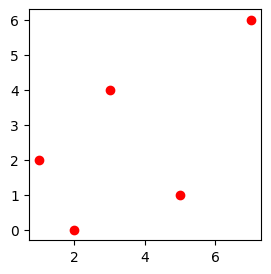

In [14]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 3, 5, 7, 2])
y = np.array([2, 4, 1, 6, 0])

plt.figure(figsize=(3,3))
plt.scatter(x, y, marker='o', c='r')
plt.show()

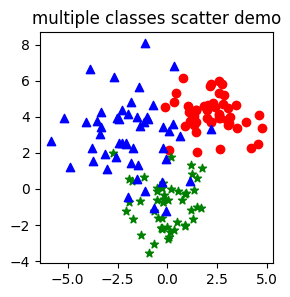

In [15]:
# Generate serveral normal subsample datasets and scatter them on the figure
size_of_class = 3
size_of_sample = 50
means = [(2,4), (0,-1), (-2,3)]
vars = [[[1,0], [0,1]], [[2,0], [0,2]], [[3,0],[0,3]]]
markers = ['o', '*', '^']
colors = ['r', 'g', 'b']

samples = []
for i in range(size_of_class):
    samples.append(np.random.multivariate_normal(means[i], vars[i], size_of_sample))

plt.figure(figsize=(3,3))
for i in range(size_of_class):
    x, y = samples[i].T
    plt.scatter(x, y, marker=markers[i], c=colors[i])
plt.title('multiple classes scatter demo')
plt.show()

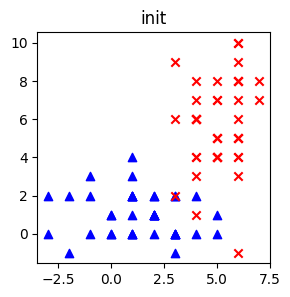

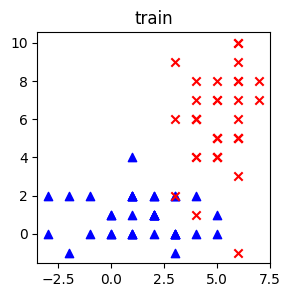

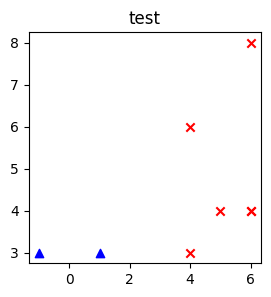

In [31]:
# Random generation of two kinds of entity and try to split them up into train dataset and test dataset.
def plot_features_and_labels(features, l, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(2):
        x = features[0, np.where(l[i, :] == 1)]
        y = features[1, np.where(l[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()

def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[1]
    indices = np.array(range(m))
    np.random.shuffle(indices)

    split_index = int(m * split_rate)
    train_indices = indices[0:split_index]
    test_indices = indices[split_index:]

    train_features = feature_matrix[:, np.array(train_indices)]
    train_labels = label_matrix[:, np.array(train_indices)]

    test_features = feature_matrix[:, np.array(test_indices)]
    test_labels = label_matrix[:, np.array(test_indices)]

    return train_features, train_labels, test_features, test_labels

size_of_class = 2
size_of_sample = 40
size_of_feature = 2
means = [(1,1), (5,5)]
vars = [[[5, 0], [0,1]], [[1,0], [0,5]]]
markers = ['^', 'x']
colors = ['b', 'r']

features = []
labels = []
for i in range(size_of_class):
    sample = np.round(np.random.multivariate_normal(means[i], vars[i], size_of_sample))
    for j in range(size_of_sample):
        label = np.zeros((size_of_class, 1))
        label[i, 0] = 1
        labels.append(label)
    features.append(sample.T)

features = np.concatenate(features, axis=1)
features.reshape((size_of_feature, size_of_sample * size_of_class))
labels = np.concatenate(labels, axis=1)
labels.reshape((size_of_class, size_of_sample * size_of_class))

train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, markers, colors, 'test')

In [45]:
# Implement yourself DNN
sigmod = lambda a: 1.0 / (1.0 + np.exp(-a))

class Neuron:
    def __init__(self, feature_size, active_function=sigmod):
        self.n = feature_size
        self.W = np.random.rand(self.n + 1, 1) # W[n, 1] 、 bias
        #self.W = np.random.uniform(-1., 1., size=(self.n + 1, 1))
        self.learning_rate = 0.07
        self.active_func = active_function

        self.X = None
        self.z = None  # z = W^T * x  ; X.shape(n+1, 1) W.shape(x+1, 1)
        self.H = None  # h = sigmod(z)

    def forward(self, x):
        m = x.shape[1]
        bais = np.ones((1, m))
        self.X = np.concatenate((x, bais), axis=0)
        self.z = self.W.T.dot(self.X)
        self.H = self.active_func(self.z)
        return self.H
    
    def backward(self, dL_by_dH):
        I = np.ones(self.H.shape)
        dH_by_dZ = (I - self.H) * self.H   # deveriate of sigmod function
        dZ_by_dW = self.X

        m = dL_by_dH.shape[1]
        a = dL_by_dH * dH_by_dZ
        a = np.ones((3, 1)).dot(a)
        dL_by_dW = a * dZ_by_dW / m
        
        #dL_by_dW = dL_by_dW.dot(np.ones((m, 1)))

        return dL_by_dW

    def predict(self, X):
        m = X.shape[1]
        bias = np.ones((1, m))
        x = np.concatenate((X, bias), axis=0)
        z = self.W.T.dot(x)
        score = self.active_func(z)
        return score

    def update_parameters(self, dL_by_dW, i):
        #i = np.random.randint(0, dL_by_dW.shape[1])
        #print('W shape:',self.W.shape, '\n i =',i, '\n dL_by_dW shape:',dL_by_dW.shape)
        x = dL_by_dW[:, i].reshape((3,1))
        #print('x shape:', x.shape)
        self.W = self.W - self.learning_rate * x
        #print('W shape:', self.W.shape)


binary_classification = lambda a: np.array([a, 1.0 - a])
class OutputLayer:
    def __init__(self, size_of_class):
        self.c = size_of_class
        self.output_func = binary_classification
        self.loss = 0.
        self.dL_by_dH = None
    
    def forward(self, s, Y):
        m = s.shape[1]
        y_hat = self.output_func(s).reshape((self.c, m))
        log_y_hat = np.log(y_hat, where= y_hat != 0)
        yy = Y * log_y_hat
        KL_matrix = np.ones((1, self.c)).dot(yy)
        self.loss = -1. * np.sum(KL_matrix)

        kk = np.divide(Y, y_hat, out=np.zeros_like(Y), where=y_hat!=0)
        self.dL_by_dH = (kk[0, :] + kk[1, :]).reshape((1, m))
        return y_hat, self.loss

    def backward(self):
        return self.dL_by_dH


def draw_neuron_boundary(neuron, features, labels, markers, colors):
    # Define the grid of points
    grid_step = 0.5
    xx, yy = np.meshgrid(np.arange(-4, 10, grid_step), np.arange(-4, 10, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Predict
    predict = neuron.predict(grid_points)

    # Create the scatter plot with decision boundary
    positive_index = np.where(predict[0,:] > 0.5)
    negative_index = np.where(predict[0,:] <= 0.5)

    plt.figure(figsize=(4, 4))
    plt.scatter(grid_points[0, positive_index], grid_points[1, positive_index], c='b', alpha=0.3)
    plt.scatter(grid_points[0, negative_index], grid_points[1, negative_index], c='y', alpha=0.3)

    for i in range(2):
        x = features[0, np.where(labels[i, :] == 1)]
        y = features[1, np.where(labels[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

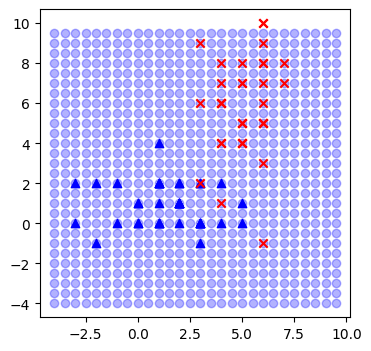

Epoch 1
-------------------------------
loss : 52.290163013955336


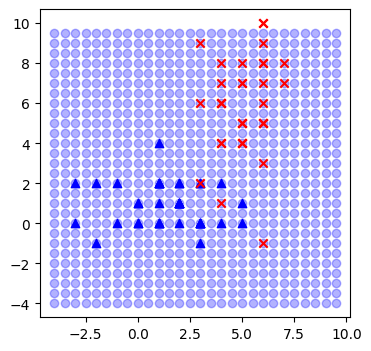

loss : 40.22394454826019


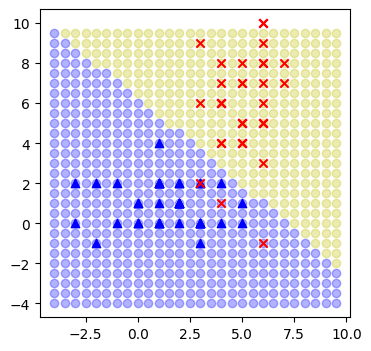

Epoch 2
-------------------------------
loss : 37.38516480156274


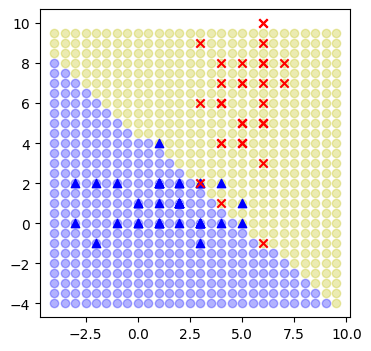

loss : 34.660264597167554


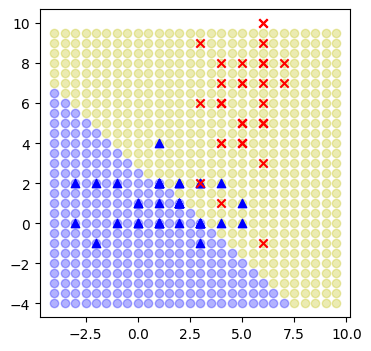

Epoch 3
-------------------------------
loss : 34.1798802028925


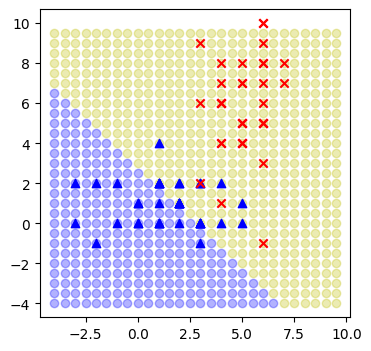

loss : 34.10171834764847


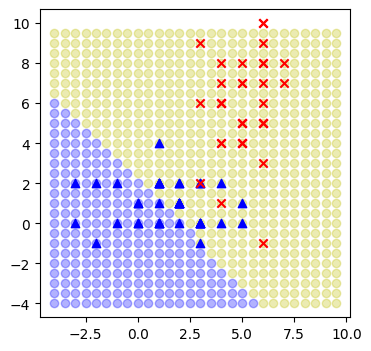

Epoch 4
-------------------------------
loss : 34.32958233633866


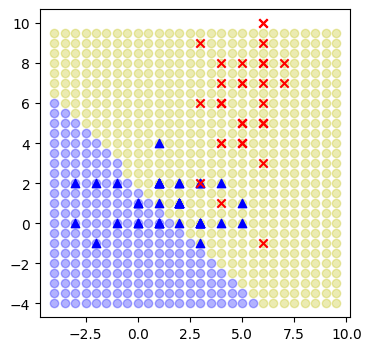

loss : 35.24630874027073


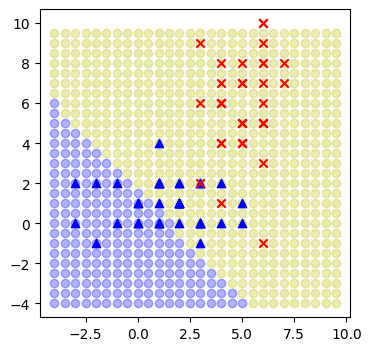

Epoch 5
-------------------------------
loss : 35.759678277778946


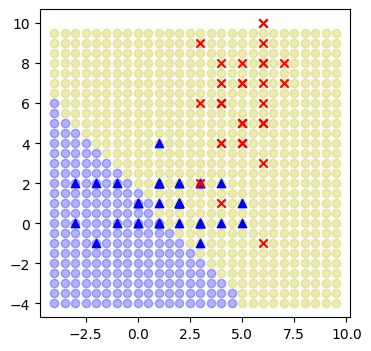

loss : 37.19367684788403


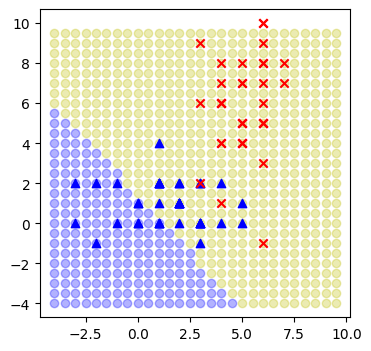

Epoch 6
-------------------------------
loss : 37.86003285685924


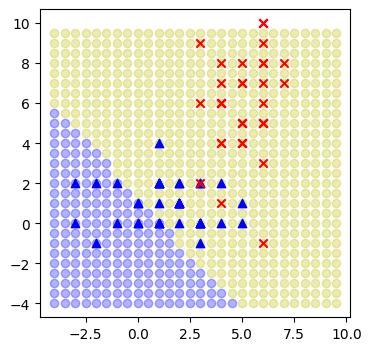

loss : 39.63577065763879


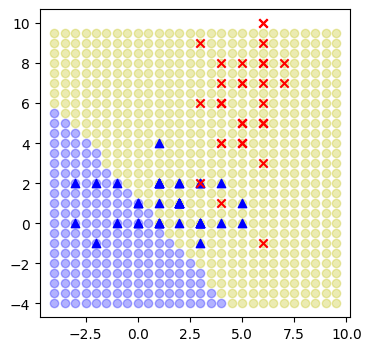

Epoch 7
-------------------------------
loss : 40.40599401908075


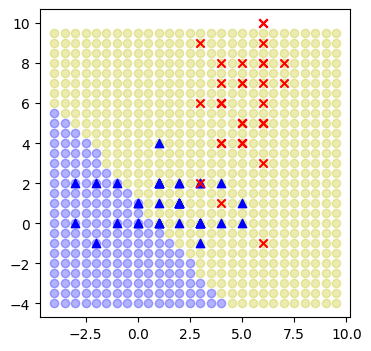

loss : 42.445220099358586


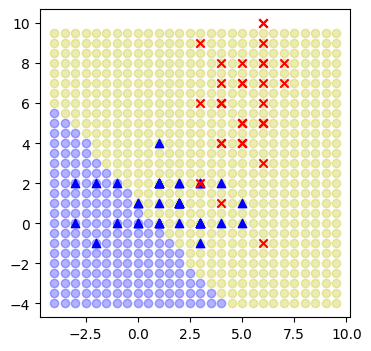

Epoch 8
-------------------------------
loss : 43.29849952756872


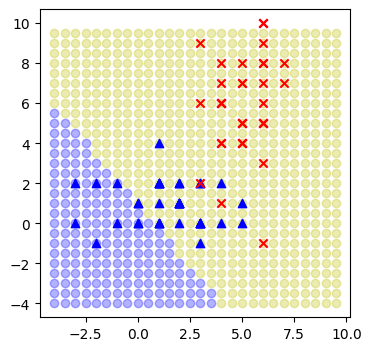

loss : 45.55979685391962


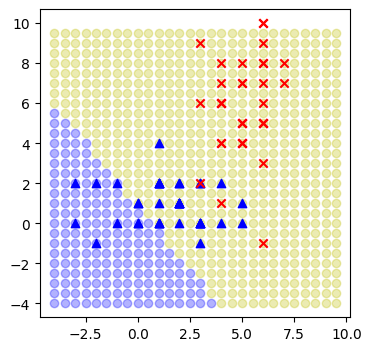

Epoch 9
-------------------------------
loss : 46.485889360157344


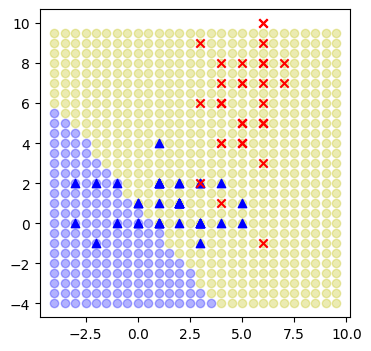

loss : 48.94328743654971


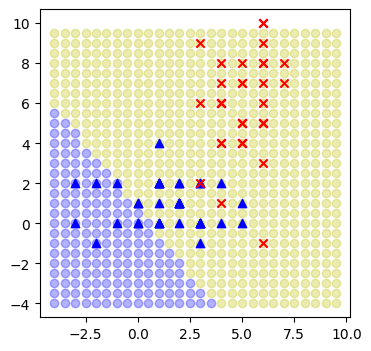

Epoch 10
-------------------------------
loss : 49.93599090172173


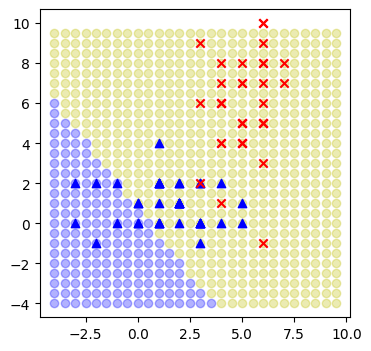

loss : 52.57040010827339


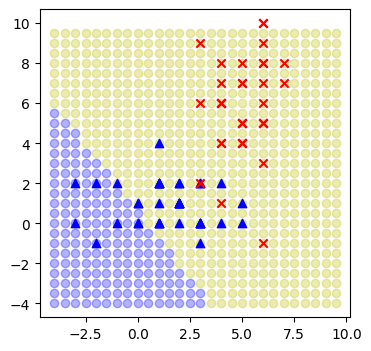

Epoch 11
-------------------------------
loss : 53.62496656961919


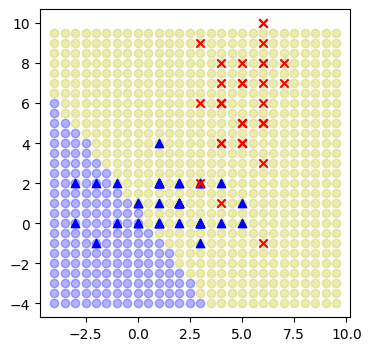

loss : 56.42049674483252


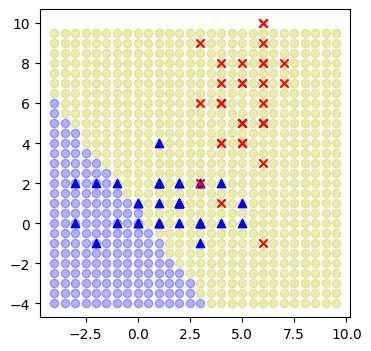

Epoch 12
-------------------------------
loss : 57.53260158517317


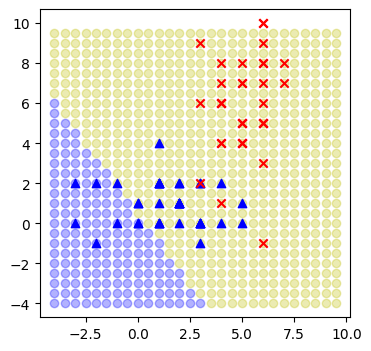

loss : 60.474955846860375


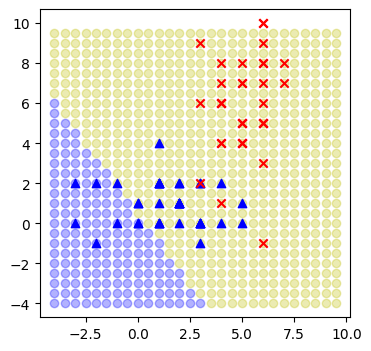

Epoch 13
-------------------------------
loss : 61.6403282886119


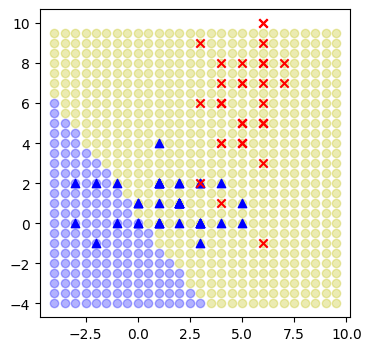

loss : 64.71614162430004


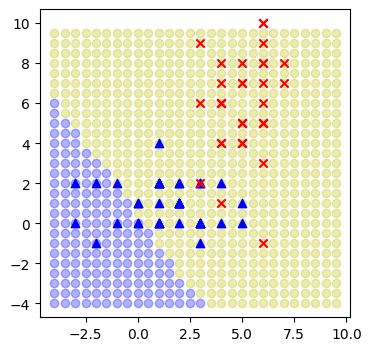

Epoch 14
-------------------------------
loss : 65.93048275656554


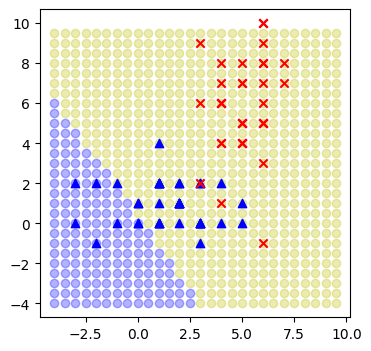

loss : 69.12710047700264


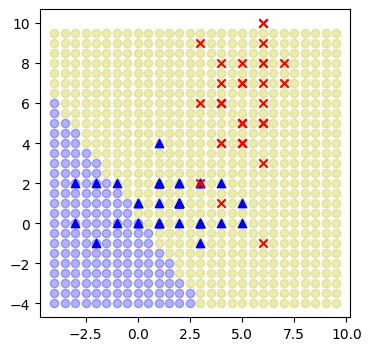

Epoch 15
-------------------------------
loss : 70.38611989902878


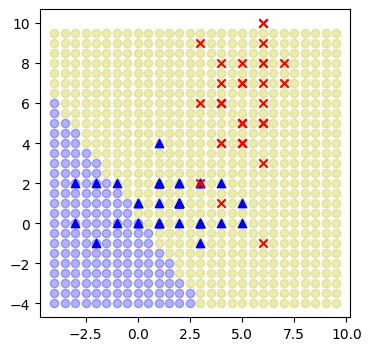

loss : 73.6915725206851


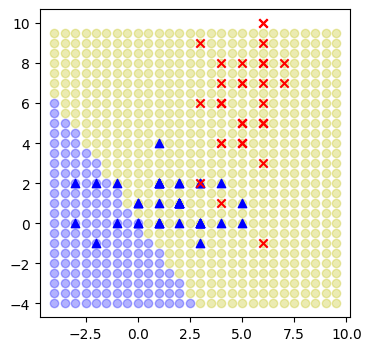

Epoch 16
-------------------------------
loss : 74.99106400955564


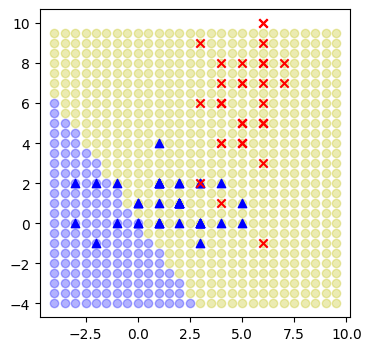

loss : 78.39411627486919


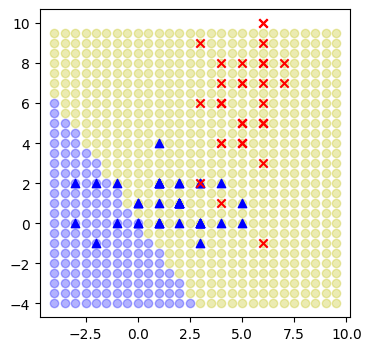

Epoch 17
-------------------------------
loss : 79.73003523792283


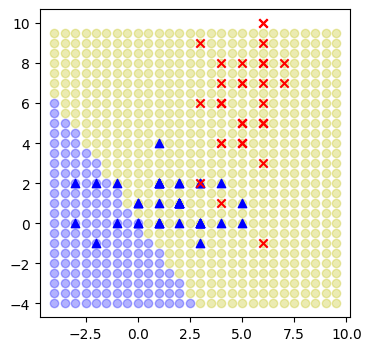

loss : 83.22024815362106


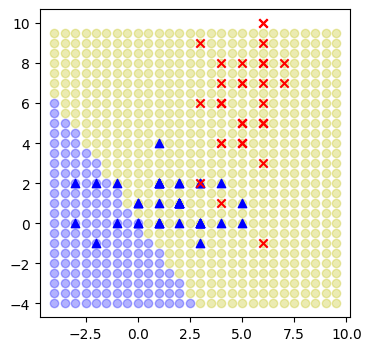

Epoch 18
-------------------------------
loss : 84.5887748756335


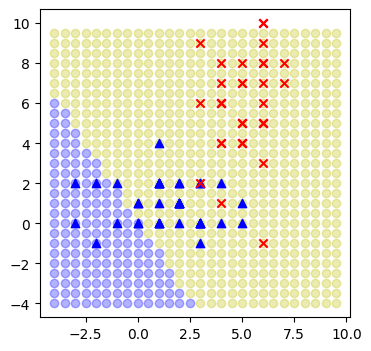

loss : 88.15655241133564


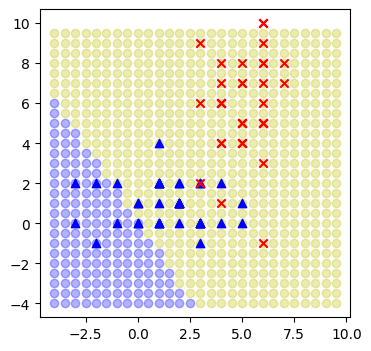

Epoch 19
-------------------------------
loss : 89.55413599646508


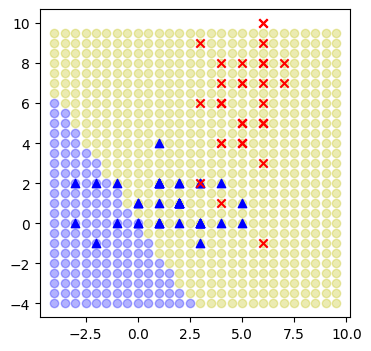

loss : 93.19074601925787


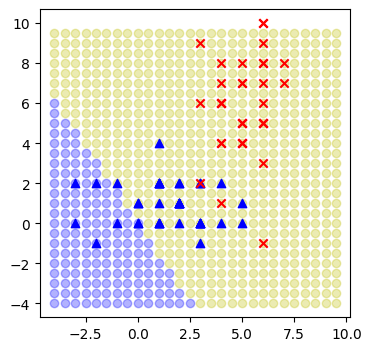

Epoch 20
-------------------------------
loss : 94.6141293714322


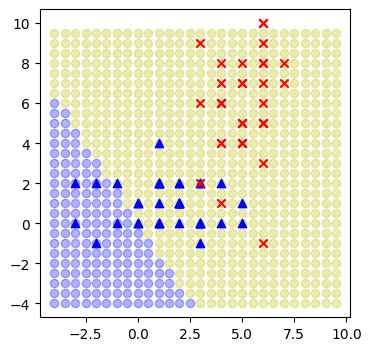

loss : 98.31169797277579


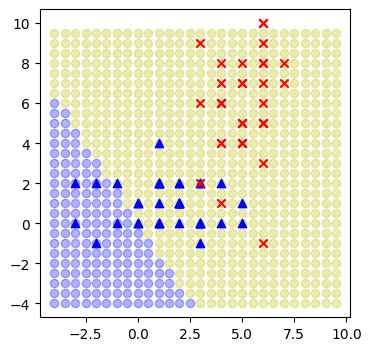

In [46]:
demo_neuron = Neuron(2)
output = OutputLayer(2)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors)

epochs = 20
m = train_labels.shape[1]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    for train_iter_id in range(m):
        h = demo_neuron.forward(train_features)
        predicts, loss = output.forward(h, train_labels)

        dL_by_dH = output.backward()
        dL_by_dW = demo_neuron.backward(dL_by_dH)
        demo_neuron.update_parameters(dL_by_dW, train_iter_id)

        if train_iter_id % 50 == 0:
            print('loss :', loss)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors)

In [47]:
def draw_neuron_boundary_2(weights, bias, features, labels, markers, colors):
    # Define the grid of points
    grid_step = 0.5
    xx, yy = np.meshgrid(np.arange(-4, 10, grid_step), np.arange(-4, 10, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Predict
    #predict = neuron.predict(grid_points)
    X = grid_points
    m = X.shape[1]
    b = np.ones((1, m))
    x = np.concatenate((X, b), axis=0)

    # weights bias tensor
    nn_weights = weights.numpy()
    nn_bias = bias.numpy().reshape((1, 1))
    W = np.concatenate((nn_weights.T, nn_bias), axis=0)
    z = W.T.dot(x)
    predict = sigmod(z)

    # Create the scatter plot with decision boundary
    positive_index = np.where(predict[0,:] > 0.5)
    negative_index = np.where(predict[0,:] <= 0.5)

    plt.figure(figsize=(4, 4))
    plt.scatter(grid_points[0, positive_index], grid_points[1, positive_index], c='b', alpha=0.1)
    plt.scatter(grid_points[0, negative_index], grid_points[1, negative_index], c='y', alpha=0.1)

    for i in range(2):
        x = features[0, np.where(labels[i, :] == 1)]
        y = features[1, np.where(labels[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

TorchNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=1, bias=True)
  (A): Sigmoid()
  (output): Linear(in_features=1, out_features=2, bias=True)
)
Epoch 1
-------------------------------
loss: 0.993989  [    1/   72]


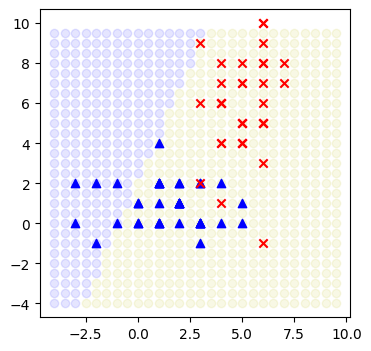

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.795157 

Epoch 2
-------------------------------
loss: 0.902190  [    1/   72]


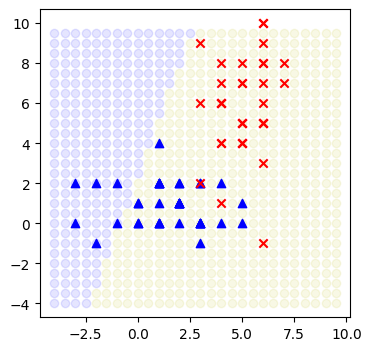

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.755994 

Epoch 3
-------------------------------
loss: 0.840287  [    1/   72]


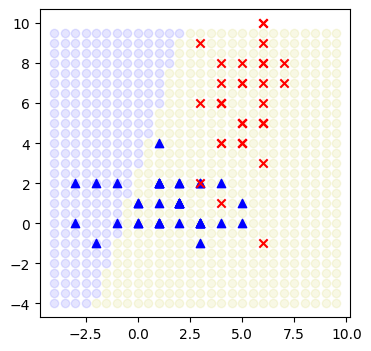

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.728850 

Epoch 4
-------------------------------
loss: 0.797677  [    1/   72]


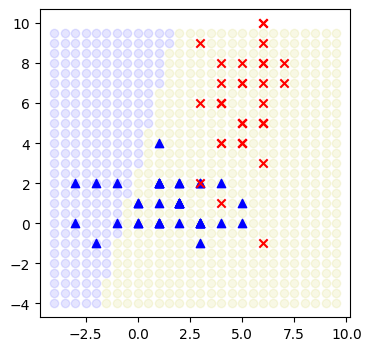

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.709247 

Epoch 5
-------------------------------
loss: 0.767690  [    1/   72]


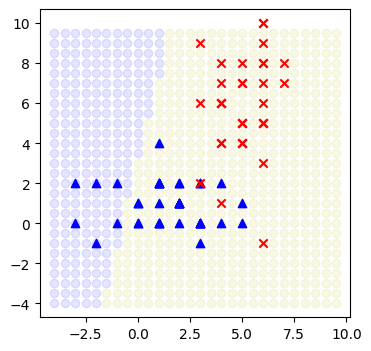

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.694500 

Epoch 6
-------------------------------
loss: 0.746062  [    1/   72]


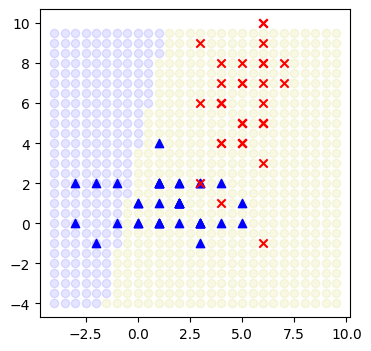

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.682944 

Epoch 7
-------------------------------
loss: 0.730020  [    1/   72]


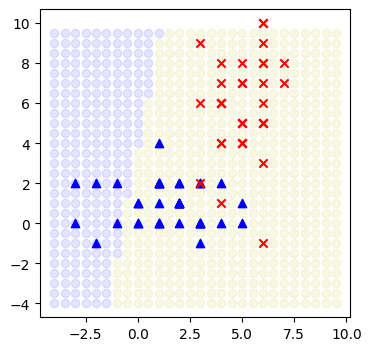

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.673518 

Epoch 8
-------------------------------
loss: 0.717742  [    1/   72]


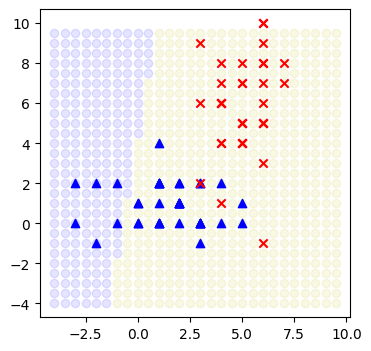

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.665530 

Epoch 9
-------------------------------
loss: 0.708011  [    1/   72]


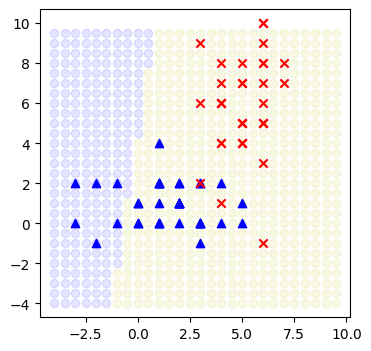

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.658520 

Epoch 10
-------------------------------
loss: 0.700009  [    1/   72]


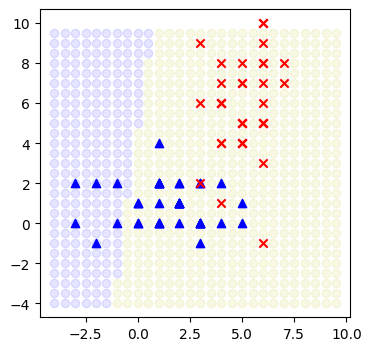

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.652178 

Epoch 11
-------------------------------
loss: 0.693179  [    1/   72]


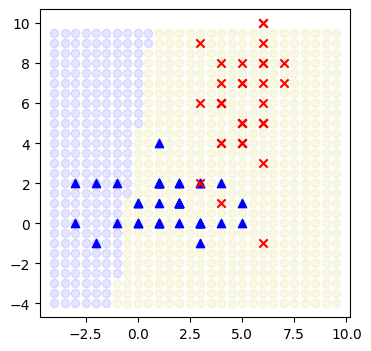

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.646294 

Epoch 12
-------------------------------
loss: 0.687142  [    1/   72]


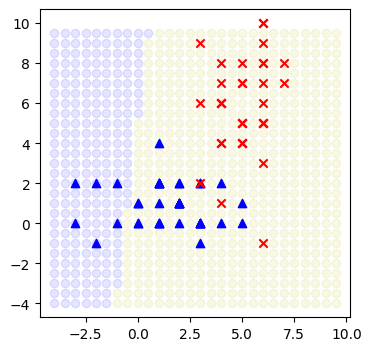

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.640722 

Epoch 13
-------------------------------
loss: 0.681636  [    1/   72]


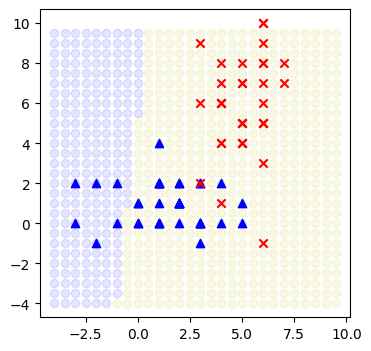

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.635363 

Epoch 14
-------------------------------
loss: 0.676481  [    1/   72]


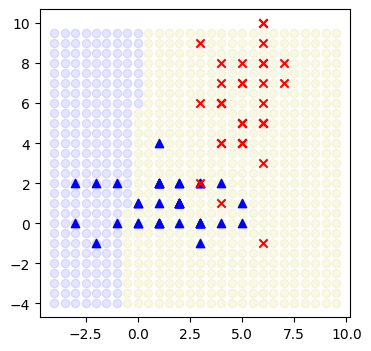

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.630148 

Epoch 15
-------------------------------
loss: 0.671551  [    1/   72]


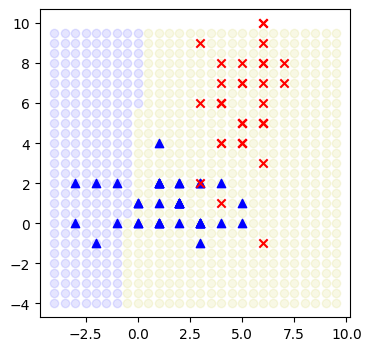

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.625028 

Epoch 16
-------------------------------
loss: 0.666756  [    1/   72]


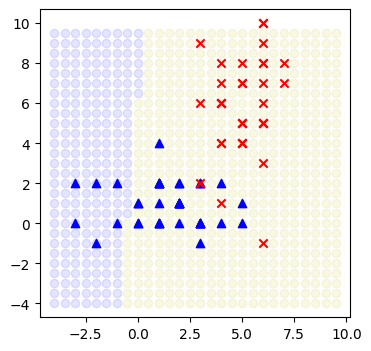

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.619971 

Epoch 17
-------------------------------
loss: 0.662036  [    1/   72]


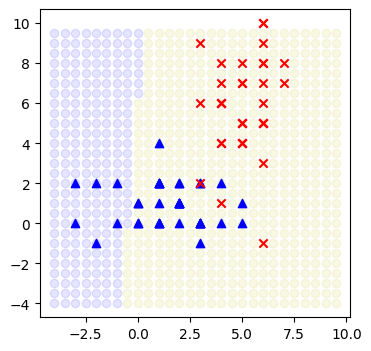

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.614954 

Epoch 18
-------------------------------
loss: 0.657343  [    1/   72]


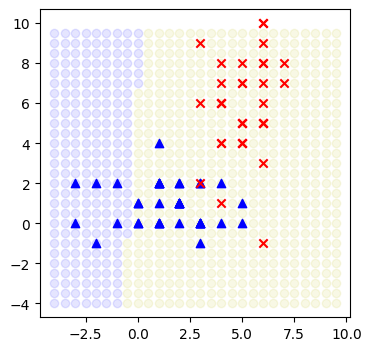

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.609961 

Epoch 19
-------------------------------
loss: 0.652646  [    1/   72]


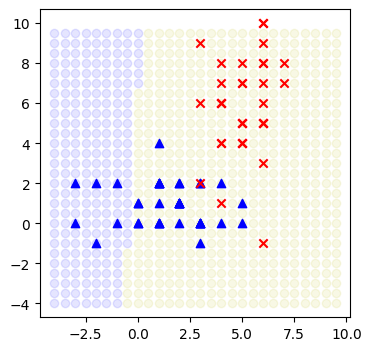

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.604983 

Epoch 20
-------------------------------
loss: 0.647920  [    1/   72]


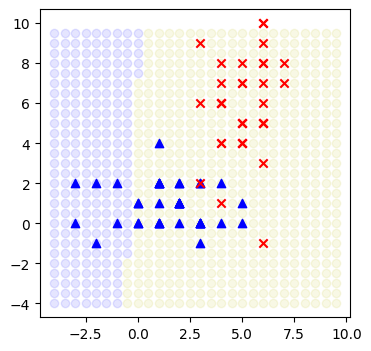

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.600013 

Epoch 21
-------------------------------
loss: 0.643147  [    1/   72]


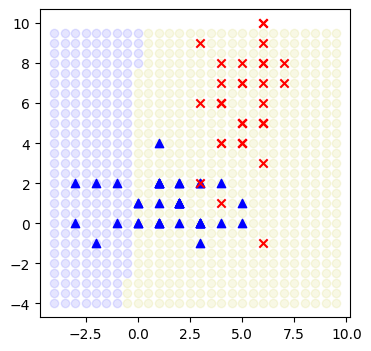

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.595048 

Epoch 22
-------------------------------
loss: 0.638312  [    1/   72]


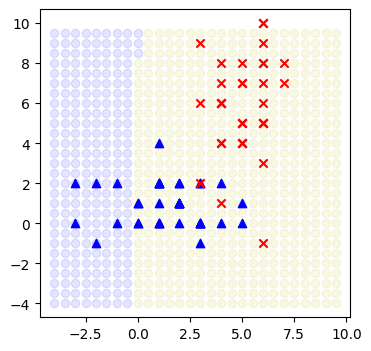

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.590085 

Epoch 23
-------------------------------
loss: 0.633405  [    1/   72]


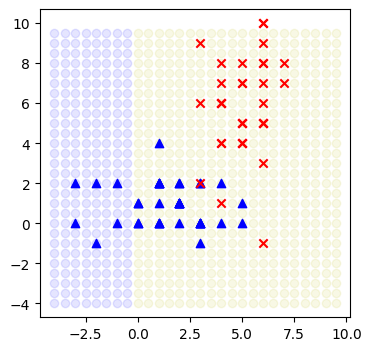

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.585124 

Epoch 24
-------------------------------
loss: 0.628417  [    1/   72]


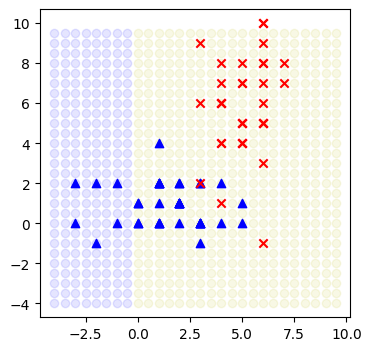

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.580168 

Epoch 25
-------------------------------
loss: 0.623341  [    1/   72]


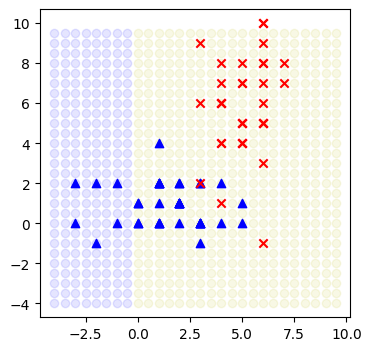

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.575217 

Epoch 26
-------------------------------
loss: 0.618171  [    1/   72]


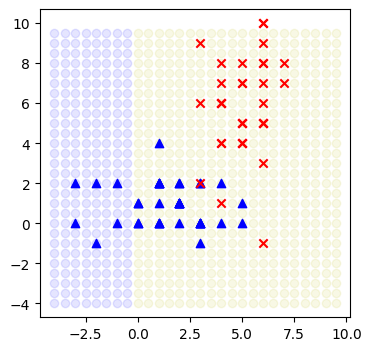

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.570277 

Epoch 27
-------------------------------
loss: 0.612905  [    1/   72]


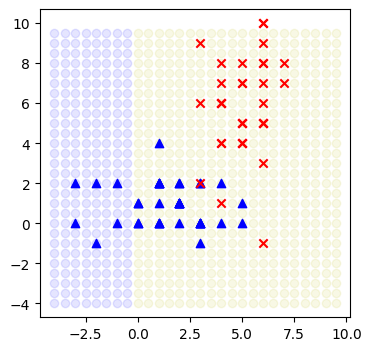

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.565351 

Epoch 28
-------------------------------
loss: 0.607542  [    1/   72]


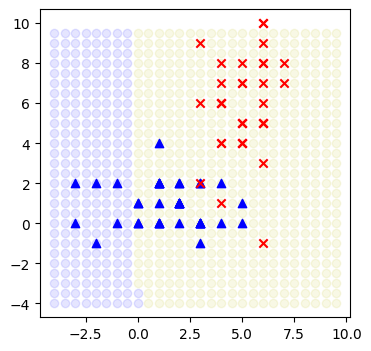

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.560447 

Epoch 29
-------------------------------
loss: 0.602083  [    1/   72]


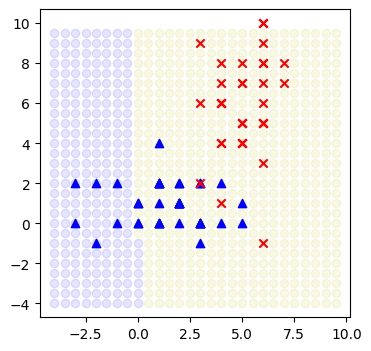

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.555572 

Epoch 30
-------------------------------
loss: 0.596537  [    1/   72]


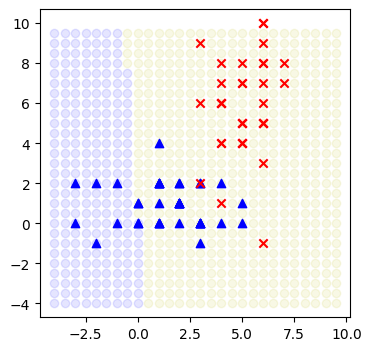

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.550738 

Epoch 31
-------------------------------
loss: 0.590916  [    1/   72]


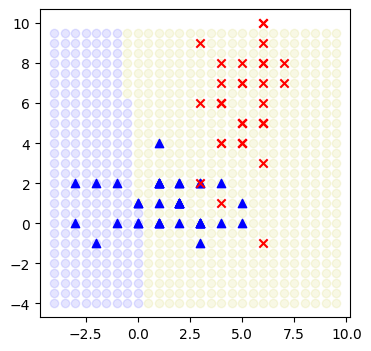

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.545957 

Epoch 32
-------------------------------
loss: 0.585240  [    1/   72]


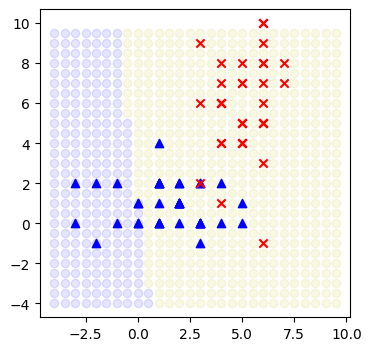

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.541245 

Epoch 33
-------------------------------
loss: 0.579542  [    1/   72]


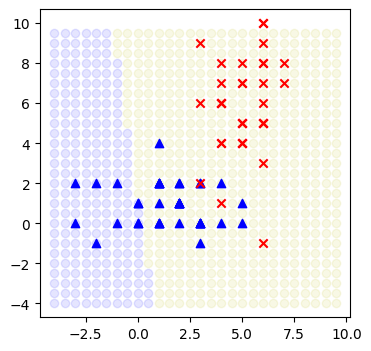

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.536617 

Epoch 34
-------------------------------
loss: 0.573864  [    1/   72]


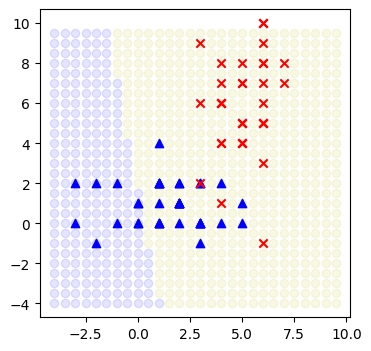

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.532091 

Epoch 35
-------------------------------
loss: 0.568266  [    1/   72]


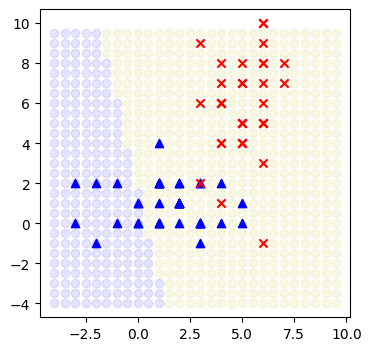

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.527677 

Epoch 36
-------------------------------
loss: 0.562817  [    1/   72]


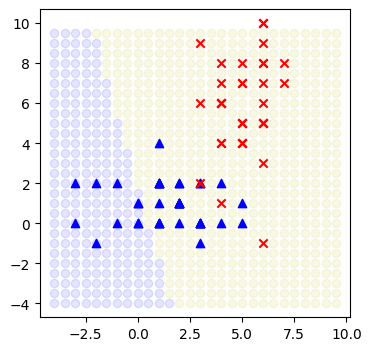

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.523375 

Epoch 37
-------------------------------
loss: 0.557592  [    1/   72]


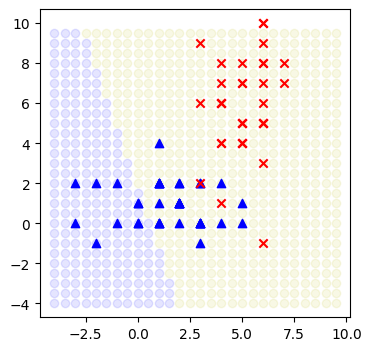

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.519166 

Epoch 38
-------------------------------
loss: 0.552654  [    1/   72]


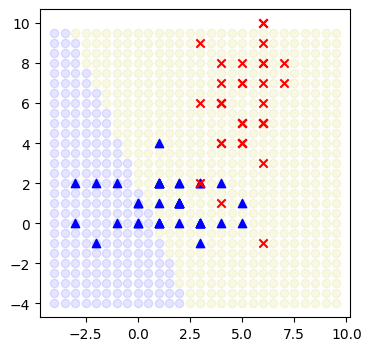

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.514997 

Epoch 39
-------------------------------
loss: 0.548029  [    1/   72]


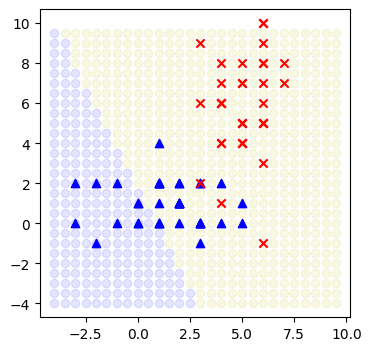

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.510779 

Epoch 40
-------------------------------
loss: 0.543674  [    1/   72]


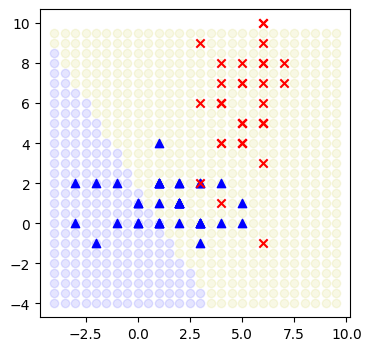

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.506386 

Epoch 41
-------------------------------
loss: 0.539453  [    1/   72]


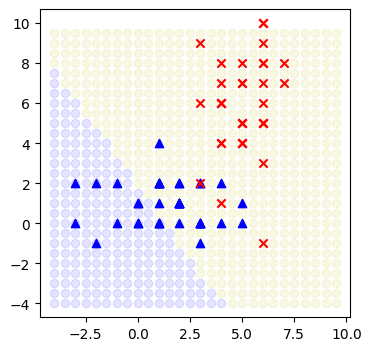

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.501676 

Epoch 42
-------------------------------
loss: 0.535147  [    1/   72]


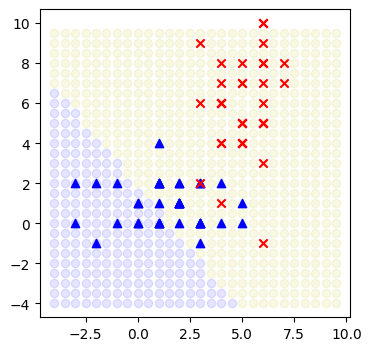

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.496518 

Epoch 43
-------------------------------
loss: 0.530498  [    1/   72]


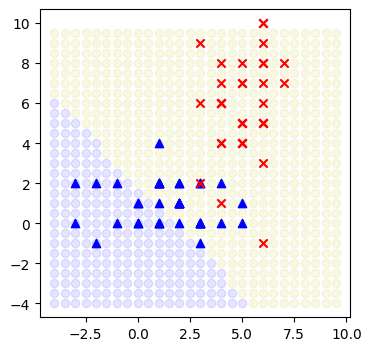

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.490826 

Epoch 44
-------------------------------
loss: 0.525279  [    1/   72]


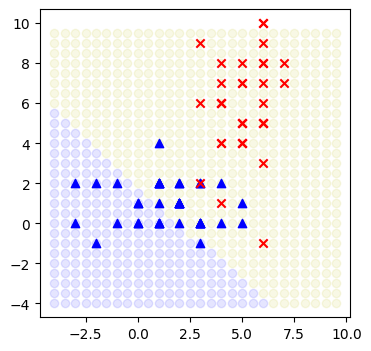

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.484567 

Epoch 45
-------------------------------
loss: 0.519350  [    1/   72]


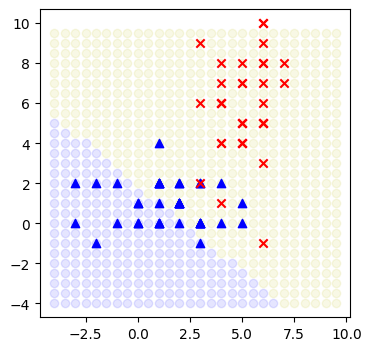

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.477765 

Epoch 46
-------------------------------
loss: 0.512672  [    1/   72]


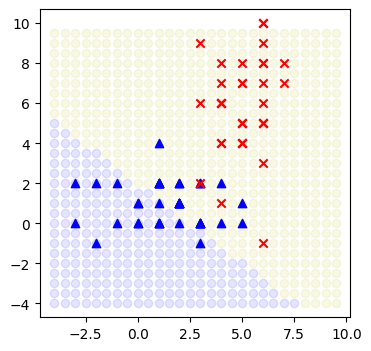

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.470473 

Epoch 47
-------------------------------
loss: 0.505288  [    1/   72]


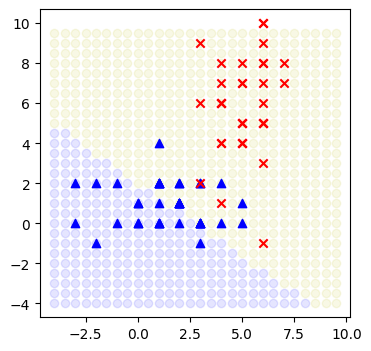

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.462763 

Epoch 48
-------------------------------
loss: 0.497291  [    1/   72]


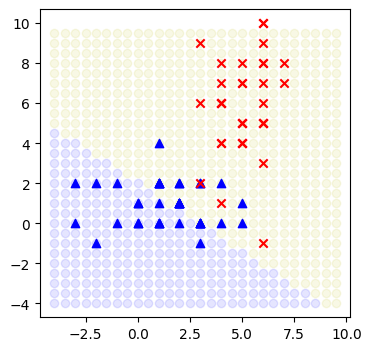

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.454708 

Epoch 49
-------------------------------
loss: 0.488787  [    1/   72]


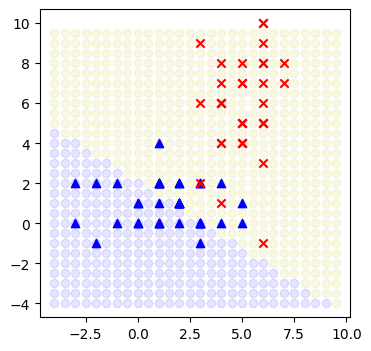

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.446379 

Epoch 50
-------------------------------
loss: 0.479885  [    1/   72]


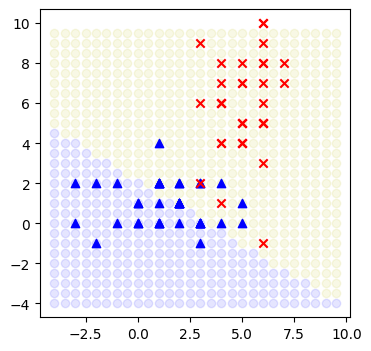

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.437840 

Epoch 51
-------------------------------
loss: 0.470681  [    1/   72]


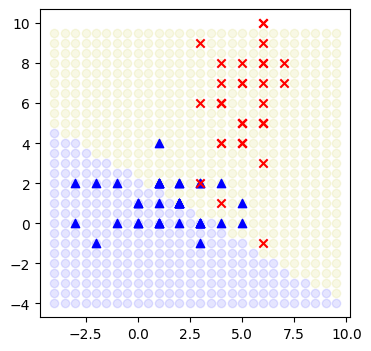

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.429148 

Epoch 52
-------------------------------
loss: 0.461260  [    1/   72]


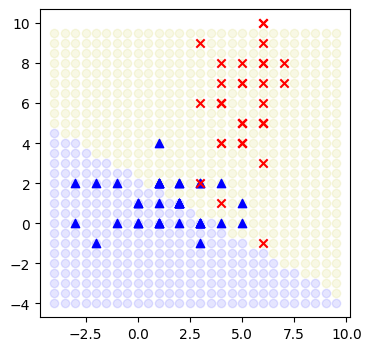

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.420356 

Epoch 53
-------------------------------
loss: 0.451695  [    1/   72]


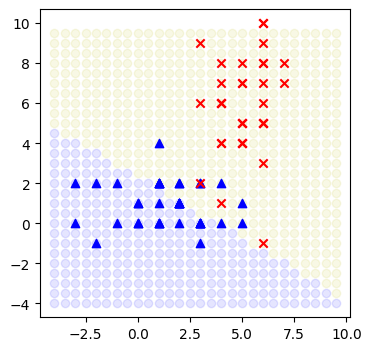

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.411511 

Epoch 54
-------------------------------
loss: 0.442050  [    1/   72]


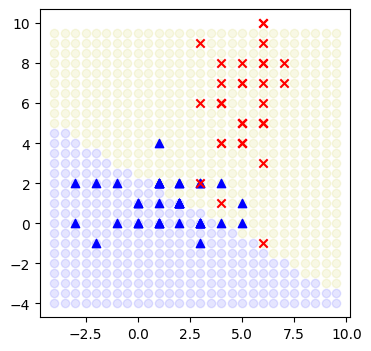

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.402654 

Epoch 55
-------------------------------
loss: 0.432377  [    1/   72]


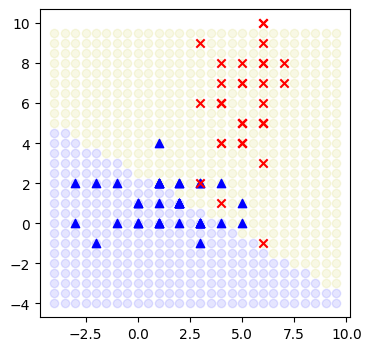

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.393823 

Epoch 56
-------------------------------
loss: 0.422723  [    1/   72]


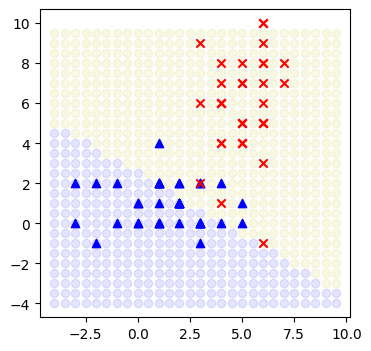

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.385052 

Epoch 57
-------------------------------
loss: 0.413127  [    1/   72]


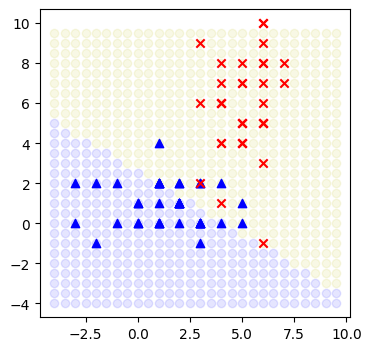

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.376368 

Epoch 58
-------------------------------
loss: 0.403622  [    1/   72]


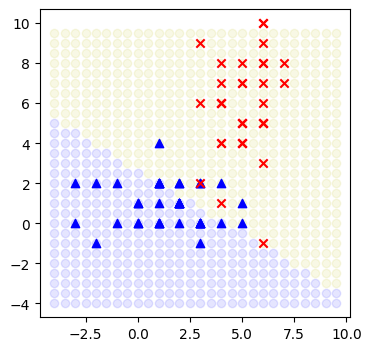

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.367798 

Epoch 59
-------------------------------
loss: 0.394236  [    1/   72]


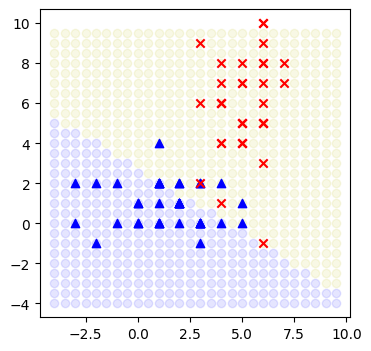

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.359361 

Epoch 60
-------------------------------
loss: 0.384992  [    1/   72]


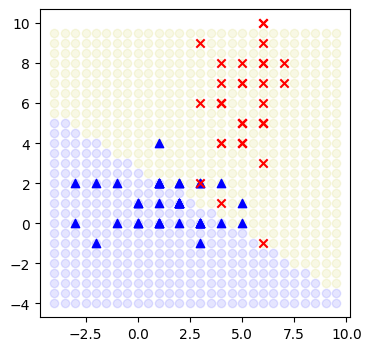

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.351077 

Epoch 61
-------------------------------
loss: 0.375909  [    1/   72]


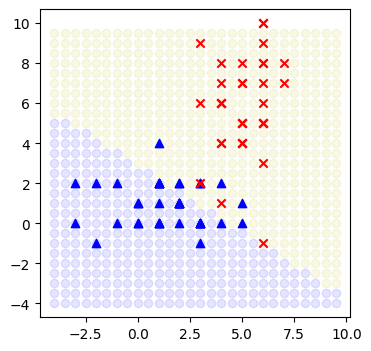

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.342959 

Epoch 62
-------------------------------
loss: 0.367004  [    1/   72]


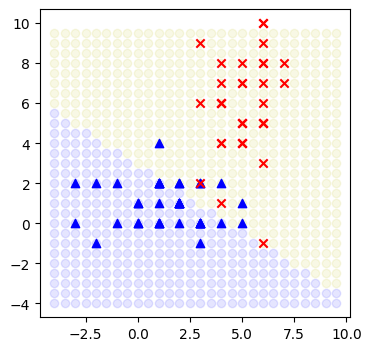

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.335020 

Epoch 63
-------------------------------
loss: 0.358288  [    1/   72]


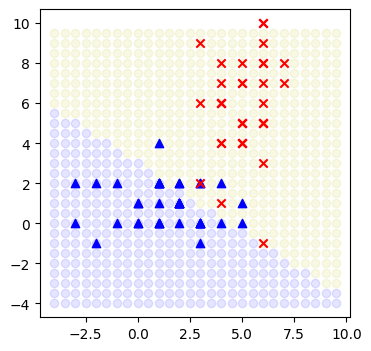

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.327270 

Epoch 64
-------------------------------
loss: 0.349772  [    1/   72]


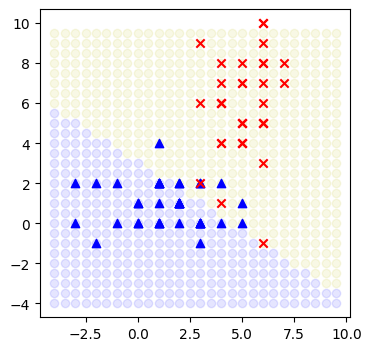

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.319714 

Epoch 65
-------------------------------
loss: 0.341462  [    1/   72]


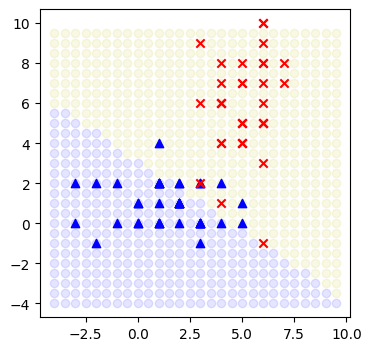

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.312358 

Epoch 66
-------------------------------
loss: 0.333363  [    1/   72]


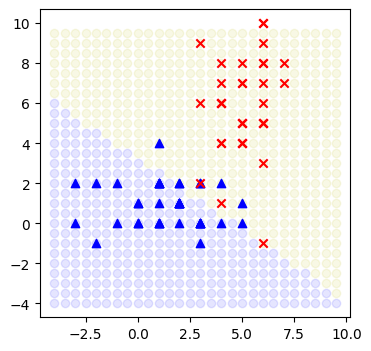

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.305206 

Epoch 67
-------------------------------
loss: 0.325480  [    1/   72]


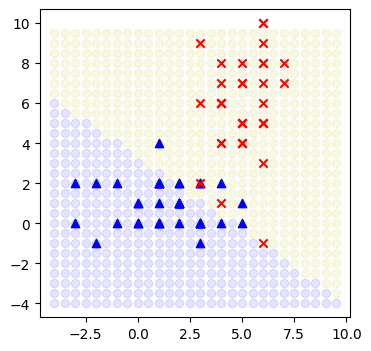

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.298258 

Epoch 68
-------------------------------
loss: 0.317813  [    1/   72]


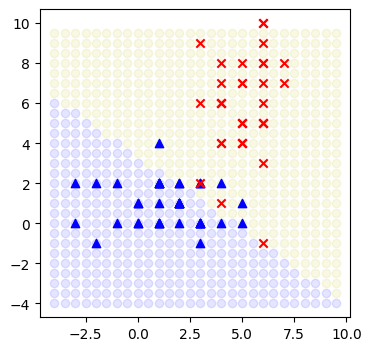

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.291516 

Epoch 69
-------------------------------
loss: 0.310363  [    1/   72]


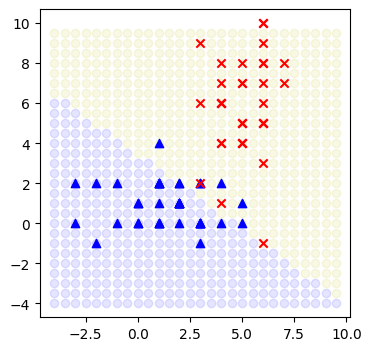

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.284978 

Epoch 70
-------------------------------
loss: 0.303129  [    1/   72]


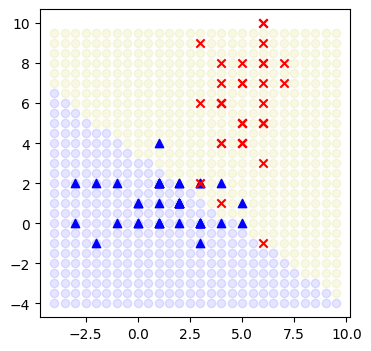

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.278642 

Epoch 71
-------------------------------
loss: 0.296109  [    1/   72]


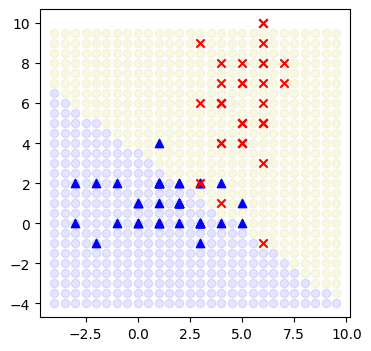

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.272505 

Epoch 72
-------------------------------
loss: 0.289301  [    1/   72]


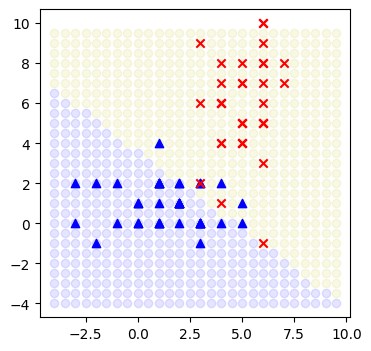

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.266565 

Epoch 73
-------------------------------
loss: 0.282701  [    1/   72]


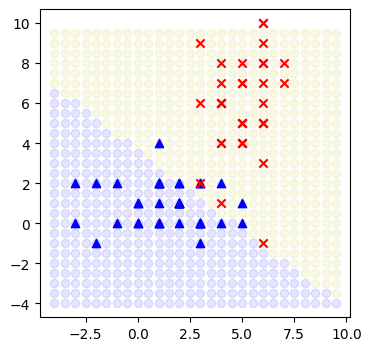

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.260816 

Epoch 74
-------------------------------
loss: 0.276305  [    1/   72]


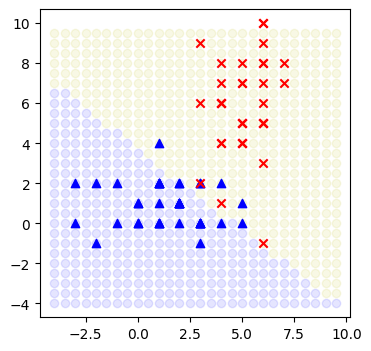

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.255256 

Epoch 75
-------------------------------
loss: 0.270108  [    1/   72]


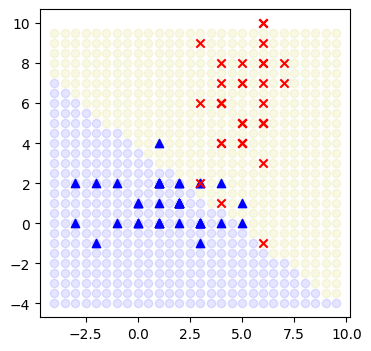

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.249878 

Epoch 76
-------------------------------
loss: 0.264107  [    1/   72]


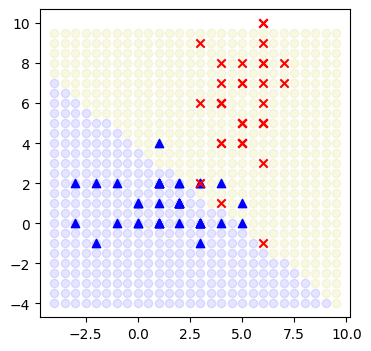

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.244677 

Epoch 77
-------------------------------
loss: 0.258296  [    1/   72]


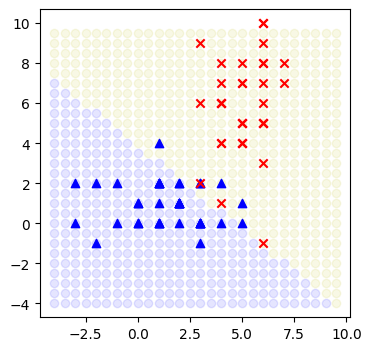

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.239650 

Epoch 78
-------------------------------
loss: 0.252670  [    1/   72]


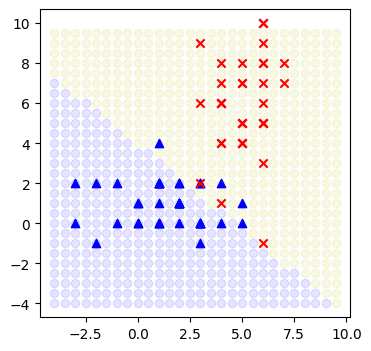

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.234789 

Epoch 79
-------------------------------
loss: 0.247224  [    1/   72]


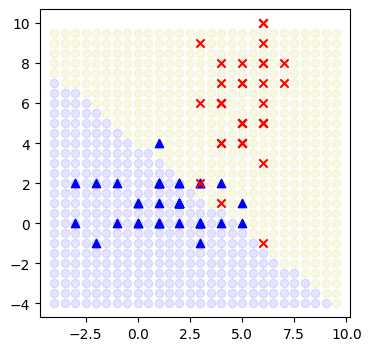

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.230090 

Epoch 80
-------------------------------
loss: 0.241951  [    1/   72]


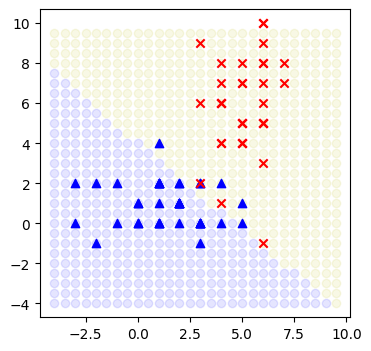

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.225547 

Epoch 81
-------------------------------
loss: 0.236846  [    1/   72]


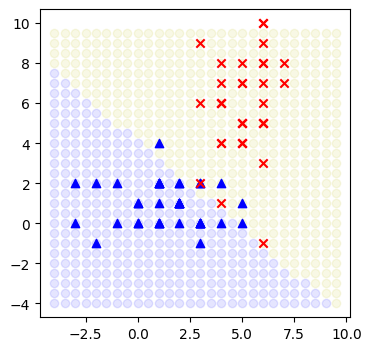

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.221154 

Epoch 82
-------------------------------
loss: 0.231905  [    1/   72]


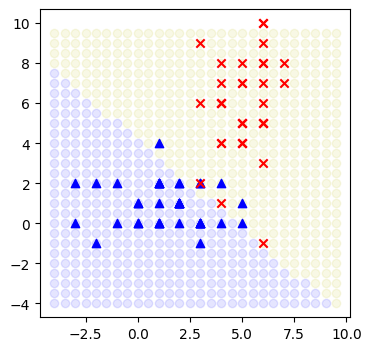

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.216907 

Epoch 83
-------------------------------
loss: 0.227121  [    1/   72]


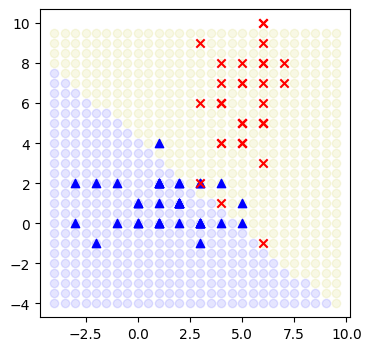

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.212801 

Epoch 84
-------------------------------
loss: 0.222489  [    1/   72]


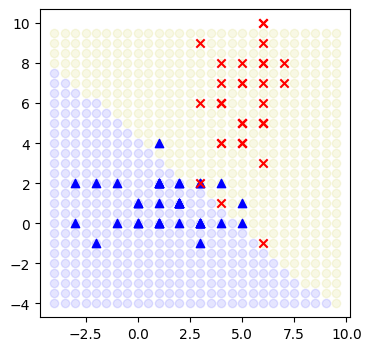

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.208829 

Epoch 85
-------------------------------
loss: 0.218004  [    1/   72]


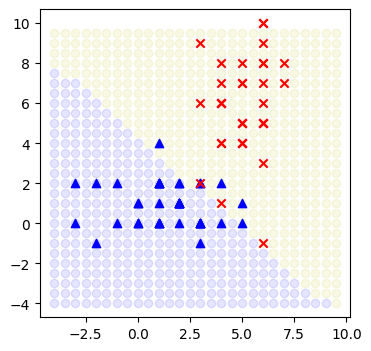

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.204987 

Epoch 86
-------------------------------
loss: 0.213661  [    1/   72]


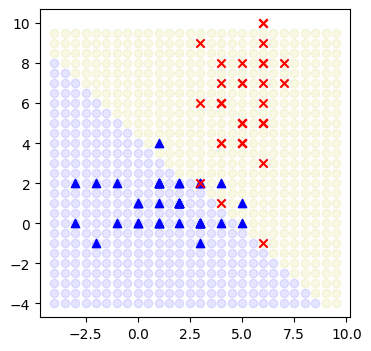

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.201269 

Epoch 87
-------------------------------
loss: 0.209454  [    1/   72]


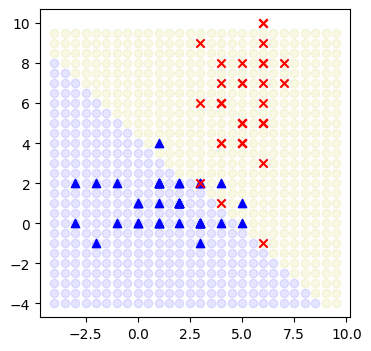

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.197672 

Epoch 88
-------------------------------
loss: 0.205379  [    1/   72]


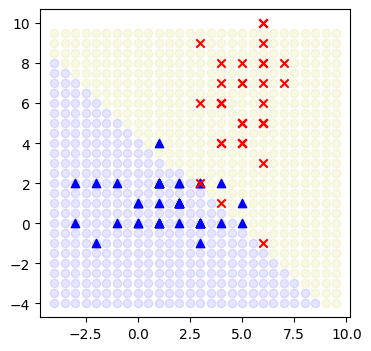

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.194191 

Epoch 89
-------------------------------
loss: 0.201431  [    1/   72]


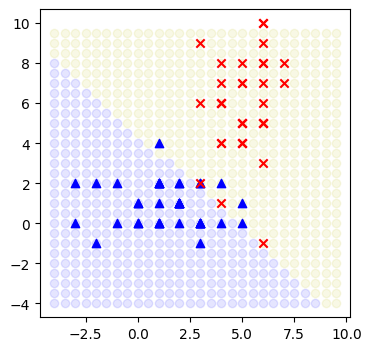

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.190820 

Epoch 90
-------------------------------
loss: 0.197605  [    1/   72]


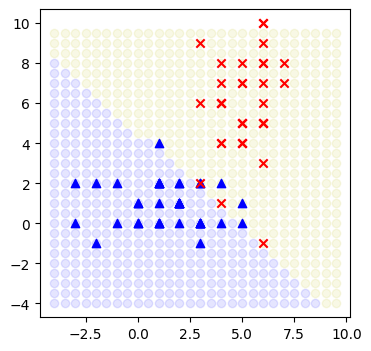

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.187557 

Epoch 91
-------------------------------
loss: 0.193897  [    1/   72]


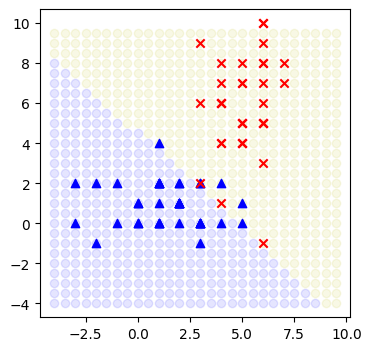

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.184396 

Epoch 92
-------------------------------
loss: 0.190301  [    1/   72]


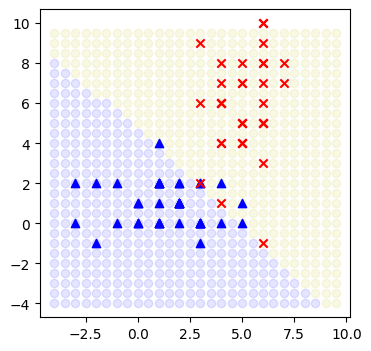

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.181334 

Epoch 93
-------------------------------
loss: 0.186816  [    1/   72]


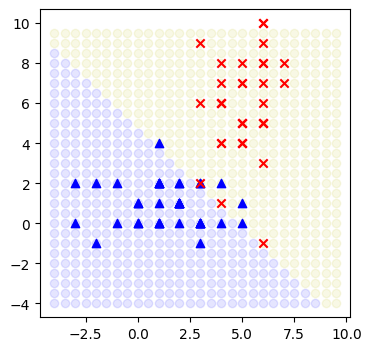

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.178366 

Epoch 94
-------------------------------
loss: 0.183435  [    1/   72]


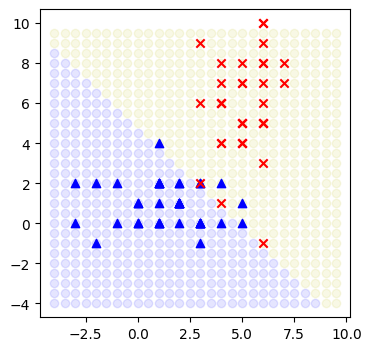

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.175490 

Epoch 95
-------------------------------
loss: 0.180156  [    1/   72]


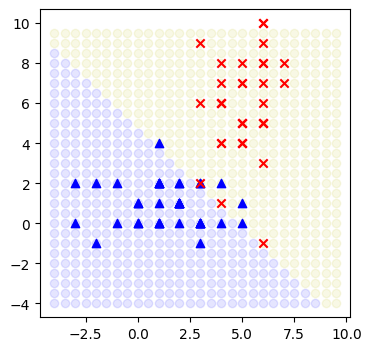

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.172701 

Epoch 96
-------------------------------
loss: 0.176974  [    1/   72]


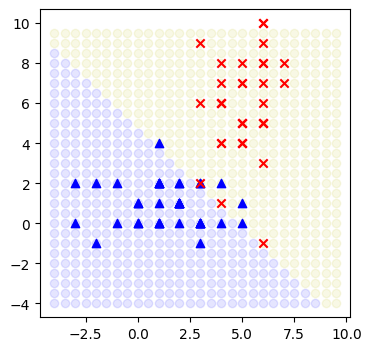

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.169997 

Epoch 97
-------------------------------
loss: 0.173886  [    1/   72]


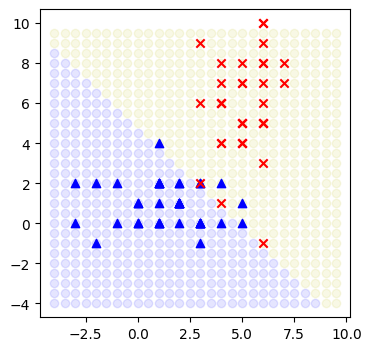

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.167374 

Epoch 98
-------------------------------
loss: 0.170889  [    1/   72]


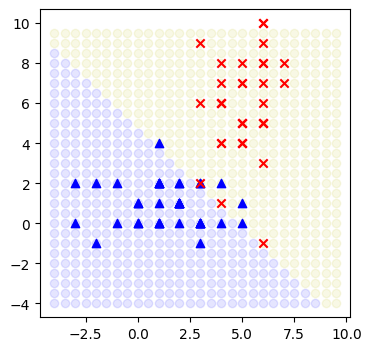

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.164828 

Epoch 99
-------------------------------
loss: 0.167978  [    1/   72]


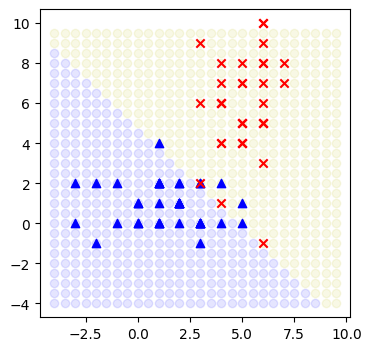

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.162358 

Epoch 100
-------------------------------
loss: 0.165152  [    1/   72]


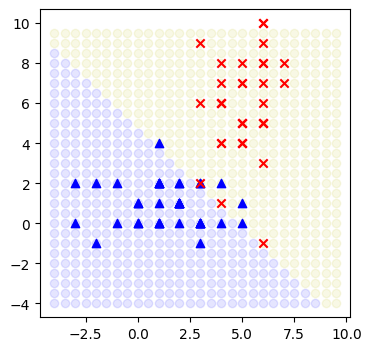

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.159960 

Epoch 101
-------------------------------
loss: 0.162407  [    1/   72]


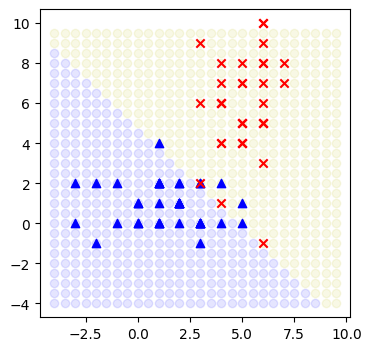

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.157631 

Epoch 102
-------------------------------
loss: 0.159739  [    1/   72]


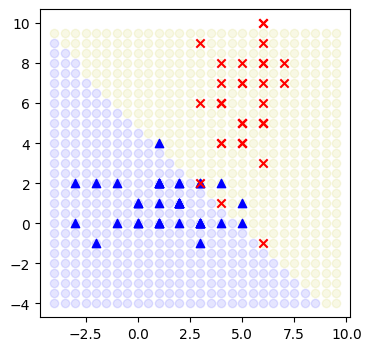

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.155369 

Epoch 103
-------------------------------
loss: 0.157147  [    1/   72]


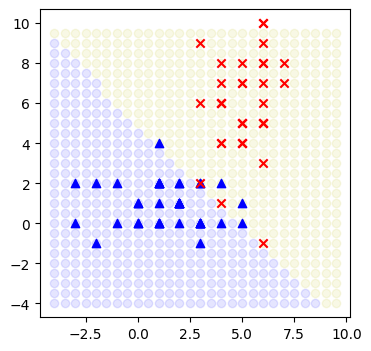

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.153171 

Epoch 104
-------------------------------
loss: 0.154626  [    1/   72]


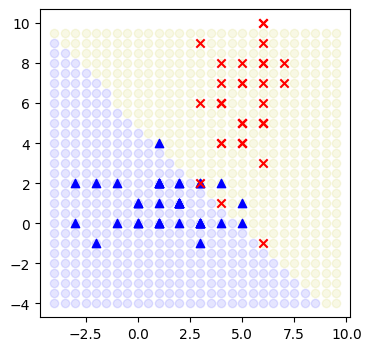

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.151035 

Epoch 105
-------------------------------
loss: 0.152176  [    1/   72]


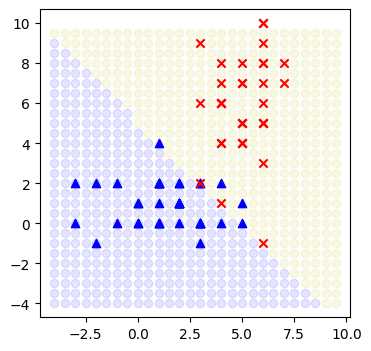

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.148959 

Epoch 106
-------------------------------
loss: 0.149793  [    1/   72]


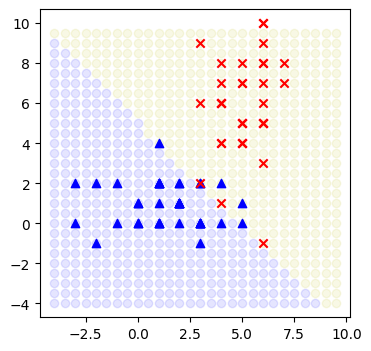

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.146941 

Epoch 107
-------------------------------
loss: 0.147475  [    1/   72]


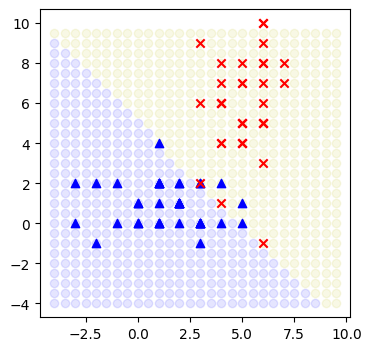

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.144977 

Epoch 108
-------------------------------
loss: 0.145220  [    1/   72]


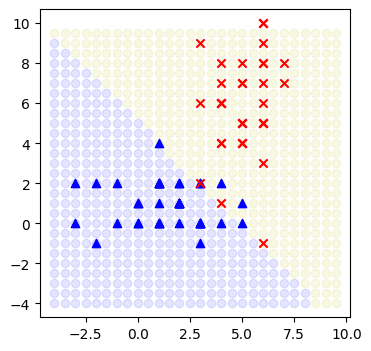

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.143067 

Epoch 109
-------------------------------
loss: 0.143025  [    1/   72]


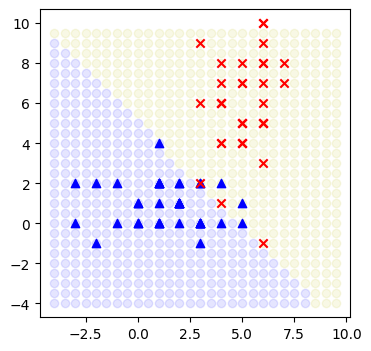

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.141208 

Epoch 110
-------------------------------
loss: 0.140888  [    1/   72]


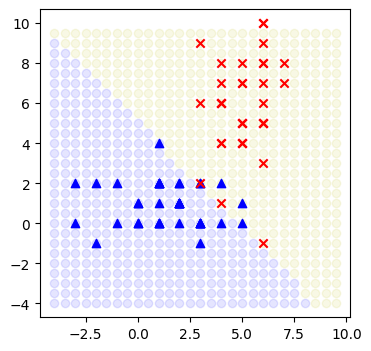

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.139399 

Epoch 111
-------------------------------
loss: 0.138808  [    1/   72]


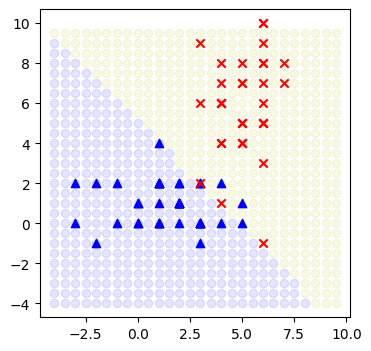

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.137638 

Epoch 112
-------------------------------
loss: 0.136782  [    1/   72]


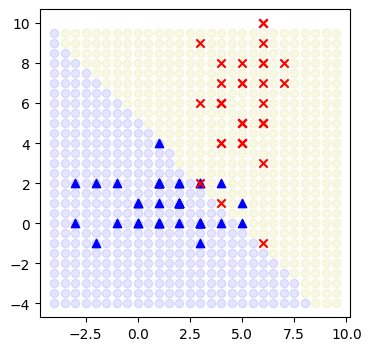

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.135923 

Epoch 113
-------------------------------
loss: 0.134808  [    1/   72]


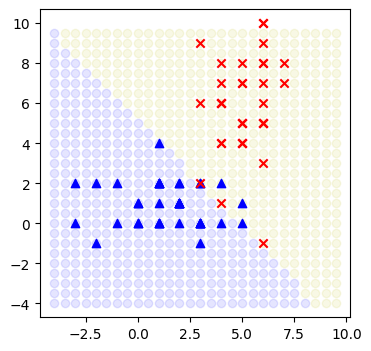

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.134253 

Epoch 114
-------------------------------
loss: 0.132886  [    1/   72]


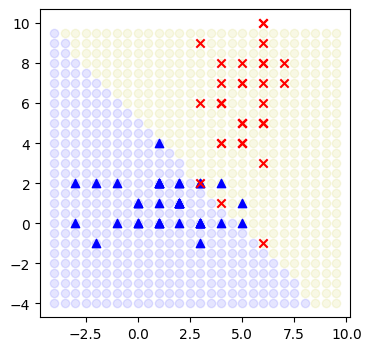

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.132625 

Epoch 115
-------------------------------
loss: 0.131012  [    1/   72]


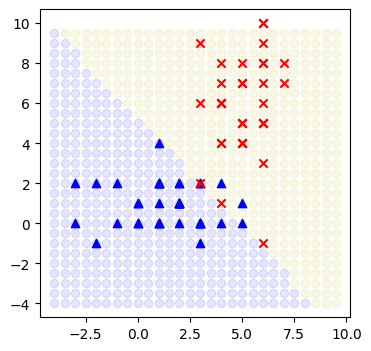

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.131039 

Epoch 116
-------------------------------
loss: 0.129185  [    1/   72]


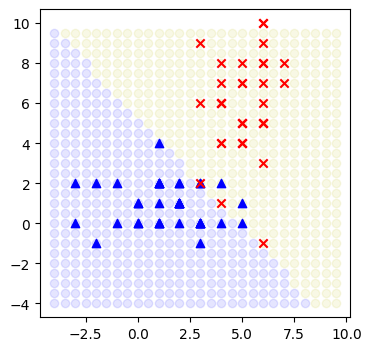

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.129493 

Epoch 117
-------------------------------
loss: 0.127405  [    1/   72]


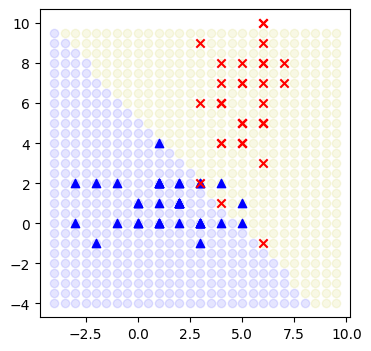

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.127986 

Epoch 118
-------------------------------
loss: 0.125668  [    1/   72]


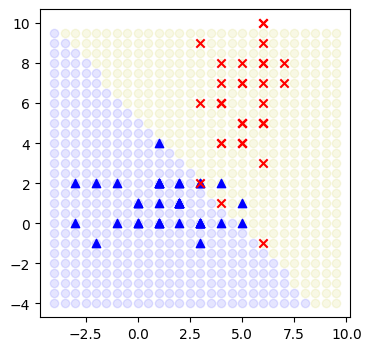

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.126516 

Epoch 119
-------------------------------
loss: 0.123974  [    1/   72]


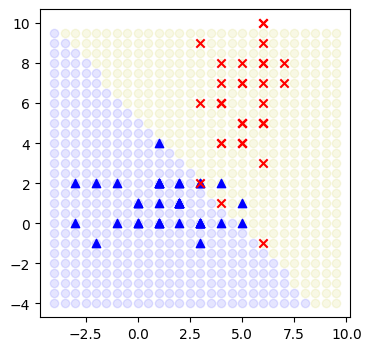

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.125083 

Epoch 120
-------------------------------
loss: 0.122322  [    1/   72]


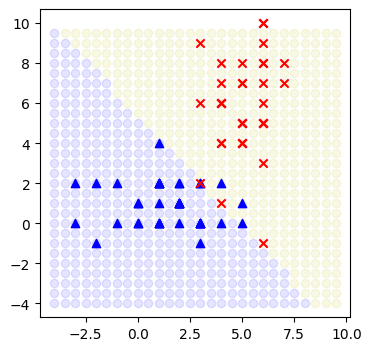

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.123684 

Epoch 121
-------------------------------
loss: 0.120710  [    1/   72]


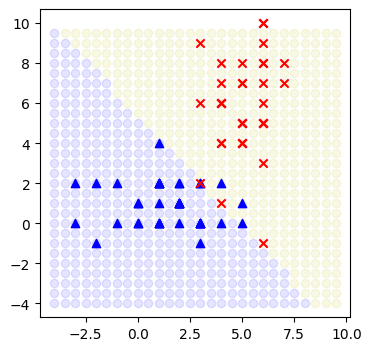

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.122320 

Epoch 122
-------------------------------
loss: 0.119136  [    1/   72]


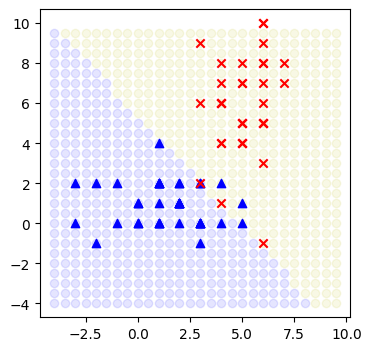

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.120988 

Epoch 123
-------------------------------
loss: 0.117600  [    1/   72]


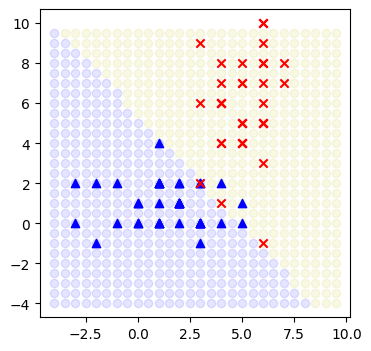

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.119687 

Epoch 124
-------------------------------
loss: 0.116100  [    1/   72]


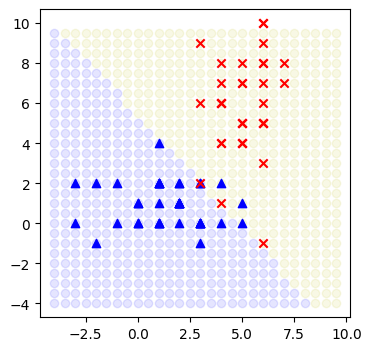

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.118418 

Epoch 125
-------------------------------
loss: 0.114636  [    1/   72]


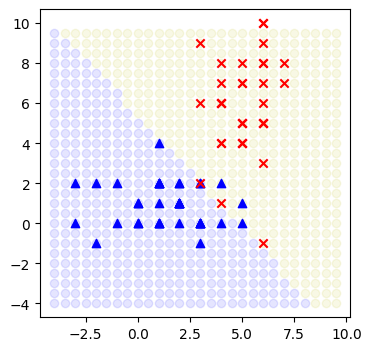

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.117178 

Epoch 126
-------------------------------
loss: 0.113205  [    1/   72]


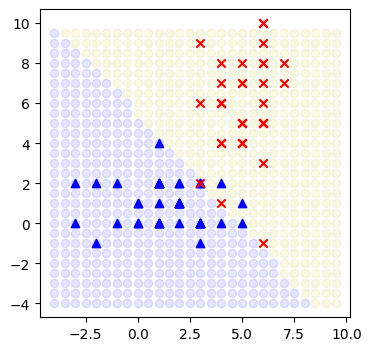

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.115966 

Epoch 127
-------------------------------
loss: 0.111808  [    1/   72]


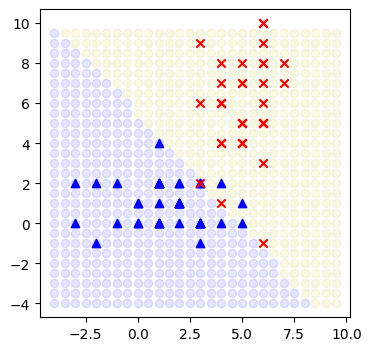

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.114783 

Epoch 128
-------------------------------
loss: 0.110442  [    1/   72]


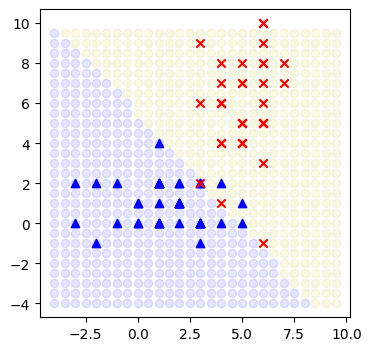

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.113626 

Epoch 129
-------------------------------
loss: 0.109107  [    1/   72]


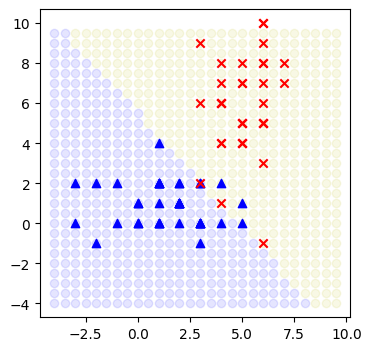

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.112496 

Epoch 130
-------------------------------
loss: 0.107802  [    1/   72]


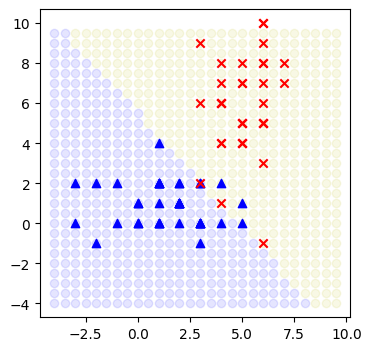

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.111391 

Epoch 131
-------------------------------
loss: 0.106527  [    1/   72]


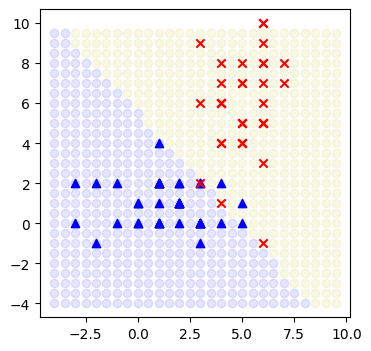

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.110310 

Epoch 132
-------------------------------
loss: 0.105279  [    1/   72]


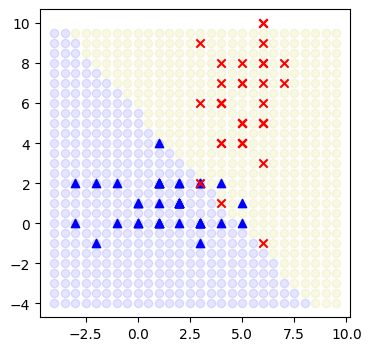

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.109254 

Epoch 133
-------------------------------
loss: 0.104059  [    1/   72]


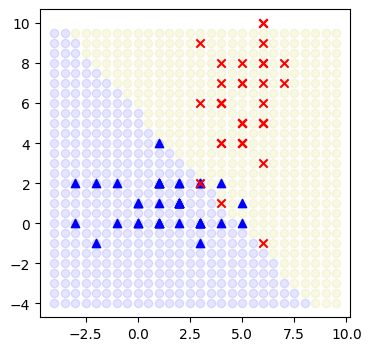

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.108220 

Epoch 134
-------------------------------
loss: 0.102866  [    1/   72]


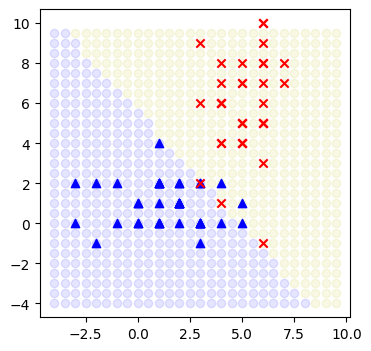

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.107209 

Epoch 135
-------------------------------
loss: 0.101699  [    1/   72]


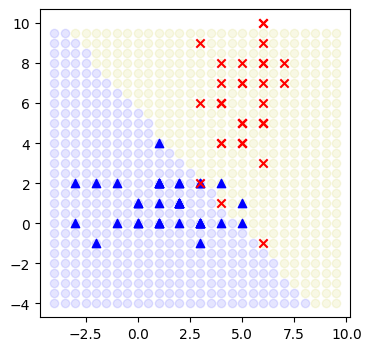

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.106219 

Epoch 136
-------------------------------
loss: 0.100556  [    1/   72]


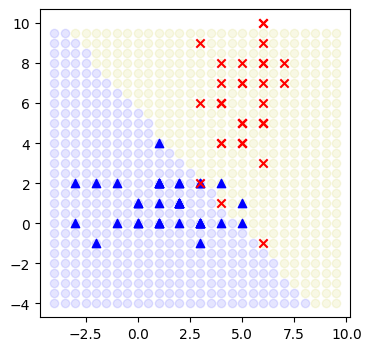

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.105251 

Epoch 137
-------------------------------
loss: 0.099438  [    1/   72]


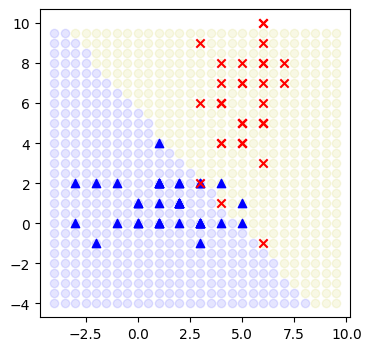

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.104303 

Epoch 138
-------------------------------
loss: 0.098343  [    1/   72]


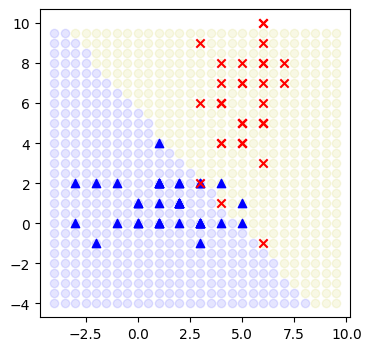

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.103375 

Epoch 139
-------------------------------
loss: 0.097271  [    1/   72]


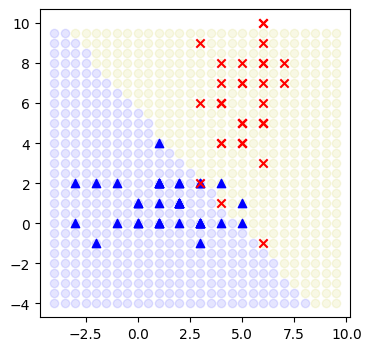

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.102466 

Epoch 140
-------------------------------
loss: 0.096222  [    1/   72]


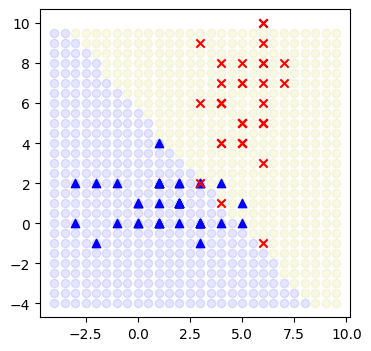

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.101577 

Epoch 141
-------------------------------
loss: 0.095194  [    1/   72]


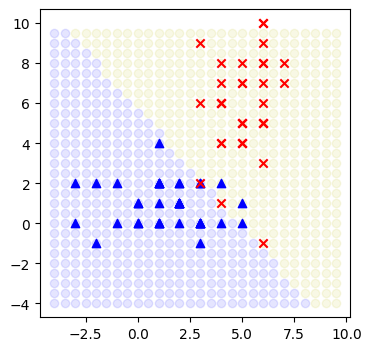

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.100705 

Epoch 142
-------------------------------
loss: 0.094187  [    1/   72]


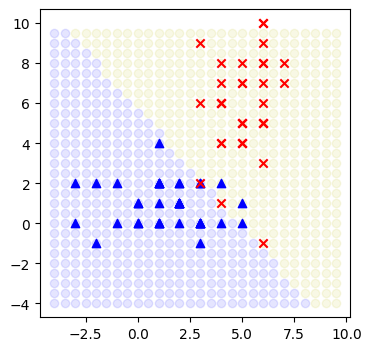

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.099851 

Epoch 143
-------------------------------
loss: 0.093201  [    1/   72]


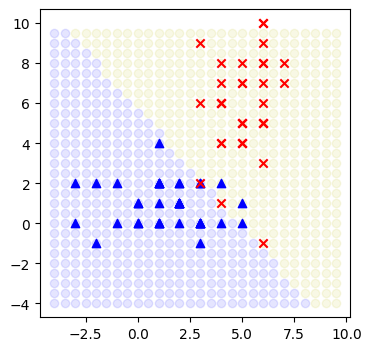

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.099014 

Epoch 144
-------------------------------
loss: 0.092234  [    1/   72]


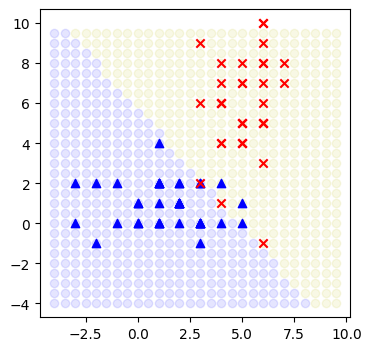

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.098195 

Epoch 145
-------------------------------
loss: 0.091287  [    1/   72]


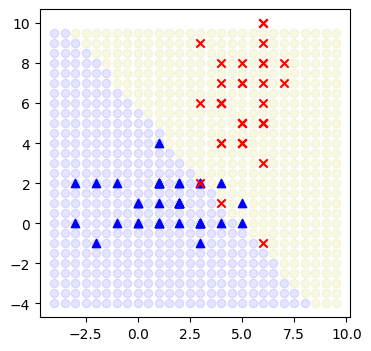

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.097391 

Epoch 146
-------------------------------
loss: 0.090358  [    1/   72]


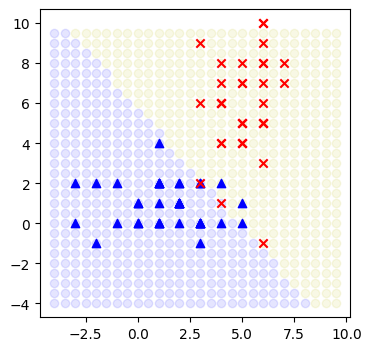

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.096603 

Epoch 147
-------------------------------
loss: 0.089448  [    1/   72]


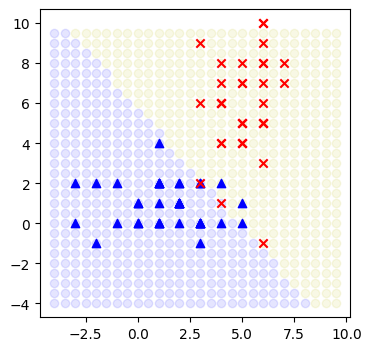

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.095831 

Epoch 148
-------------------------------
loss: 0.088556  [    1/   72]


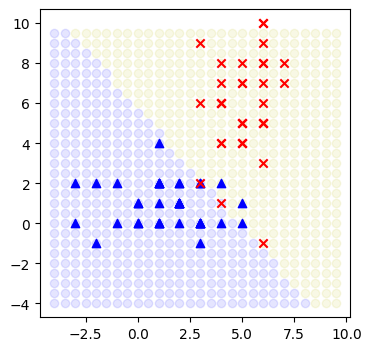

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.095074 

Epoch 149
-------------------------------
loss: 0.087681  [    1/   72]


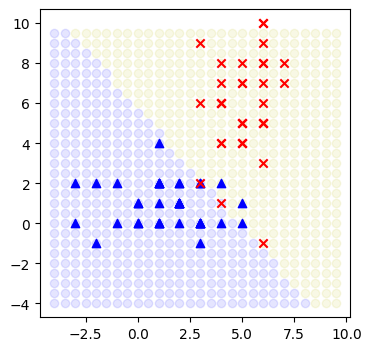

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.094331 

Epoch 150
-------------------------------
loss: 0.086823  [    1/   72]


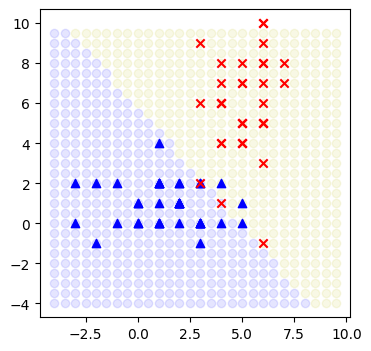

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.093603 

Epoch 151
-------------------------------
loss: 0.085981  [    1/   72]


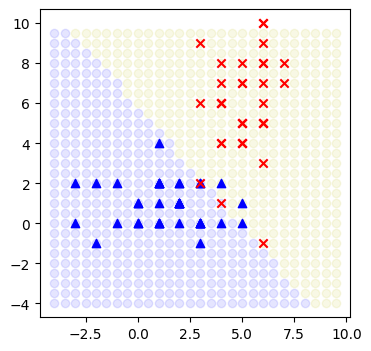

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.092888 

Epoch 152
-------------------------------
loss: 0.085155  [    1/   72]


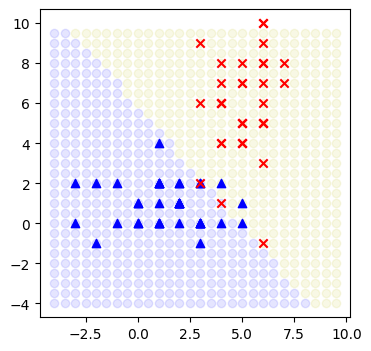

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.092187 

Epoch 153
-------------------------------
loss: 0.084345  [    1/   72]


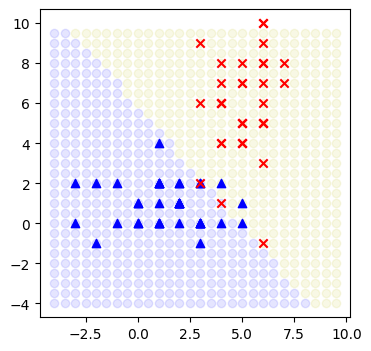

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.091499 

Epoch 154
-------------------------------
loss: 0.083550  [    1/   72]


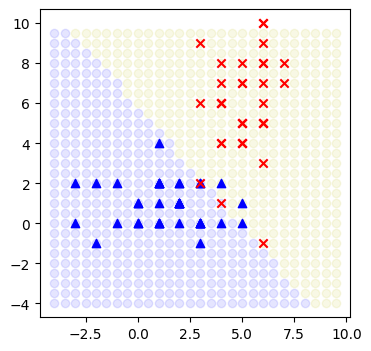

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.090824 

Epoch 155
-------------------------------
loss: 0.082770  [    1/   72]


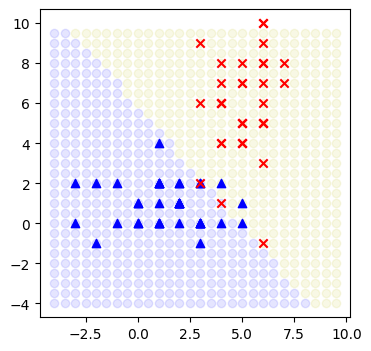

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.090162 

Epoch 156
-------------------------------
loss: 0.082004  [    1/   72]


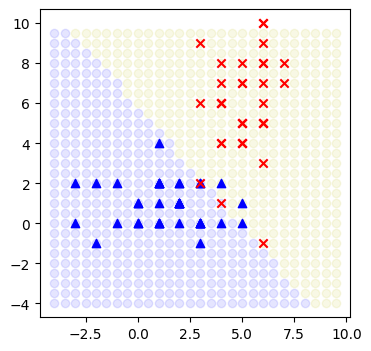

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.089511 

Epoch 157
-------------------------------
loss: 0.081252  [    1/   72]


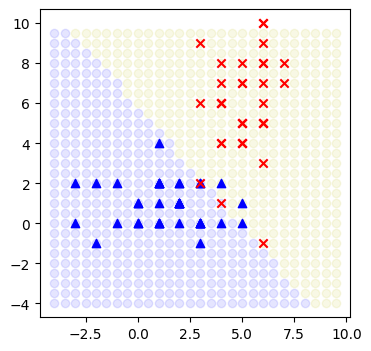

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.088873 

Epoch 158
-------------------------------
loss: 0.080513  [    1/   72]


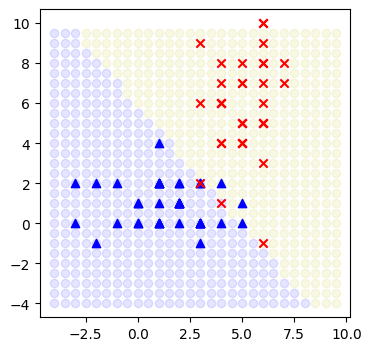

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.088246 

Epoch 159
-------------------------------
loss: 0.079788  [    1/   72]


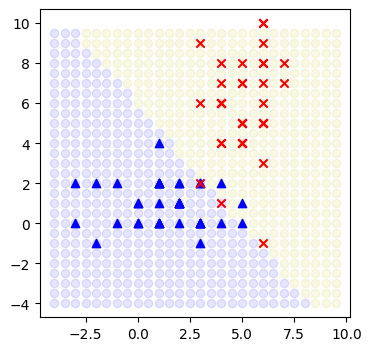

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.087630 

Epoch 160
-------------------------------
loss: 0.079077  [    1/   72]


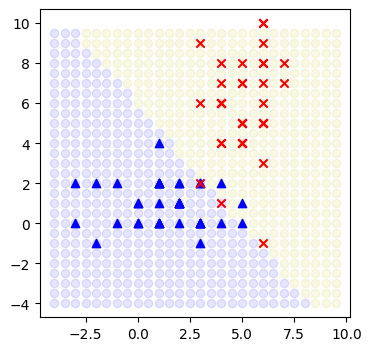

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.087025 

Epoch 161
-------------------------------
loss: 0.078377  [    1/   72]


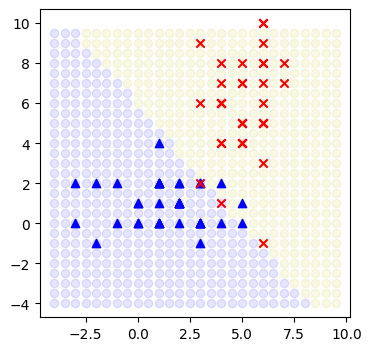

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.086431 

Epoch 162
-------------------------------
loss: 0.077690  [    1/   72]


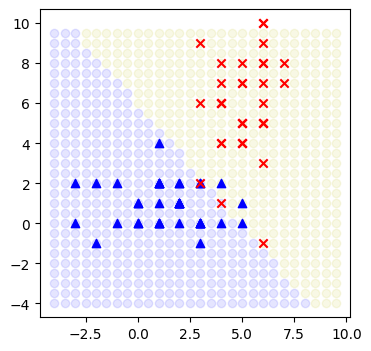

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.085848 

Epoch 163
-------------------------------
loss: 0.077015  [    1/   72]


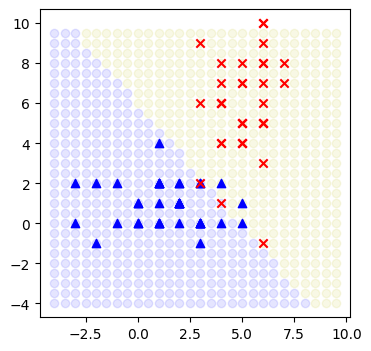

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.085275 

Epoch 164
-------------------------------
loss: 0.076352  [    1/   72]


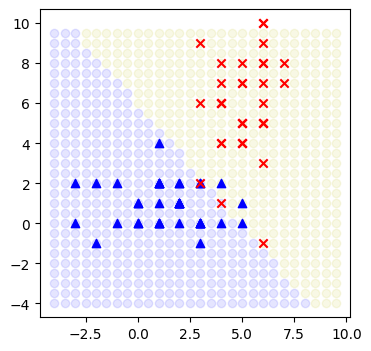

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.084711 

Epoch 165
-------------------------------
loss: 0.075701  [    1/   72]


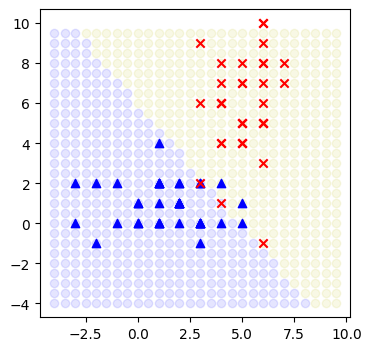

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.084158 

Epoch 166
-------------------------------
loss: 0.075060  [    1/   72]


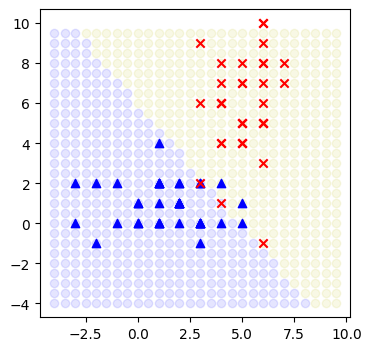

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.083614 

Epoch 167
-------------------------------
loss: 0.074431  [    1/   72]


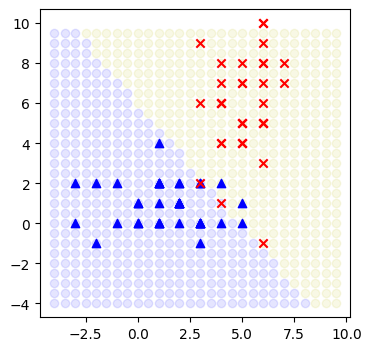

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.083079 

Epoch 168
-------------------------------
loss: 0.073812  [    1/   72]


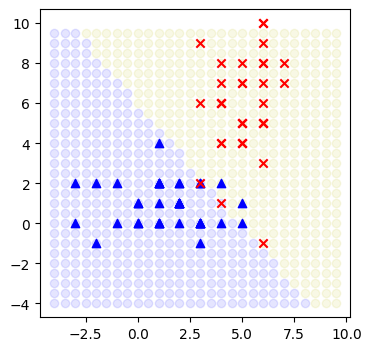

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.082554 

Epoch 169
-------------------------------
loss: 0.073203  [    1/   72]


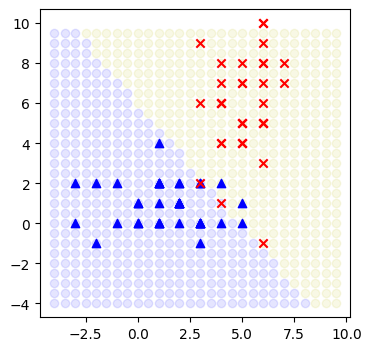

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.082037 

Epoch 170
-------------------------------
loss: 0.072605  [    1/   72]


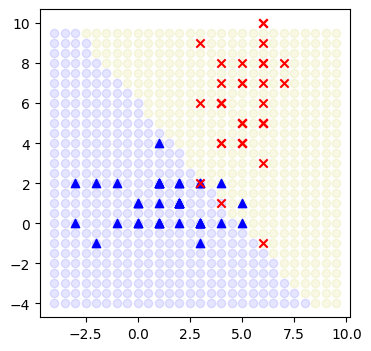

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.081529 

Epoch 171
-------------------------------
loss: 0.072017  [    1/   72]


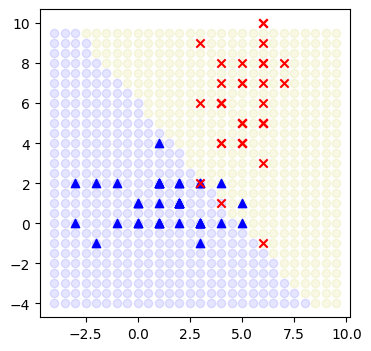

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.081029 

Epoch 172
-------------------------------
loss: 0.071438  [    1/   72]


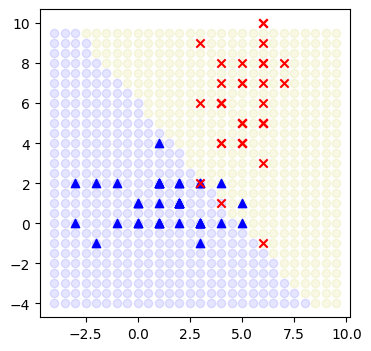

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.080538 

Epoch 173
-------------------------------
loss: 0.070869  [    1/   72]


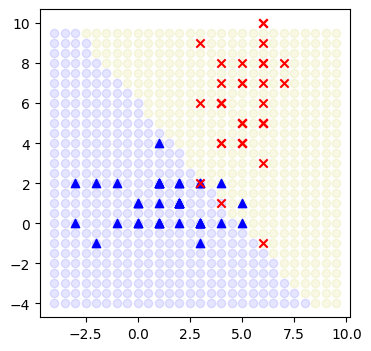

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.080055 

Epoch 174
-------------------------------
loss: 0.070309  [    1/   72]


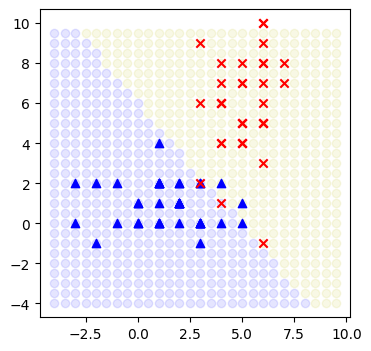

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.079579 

Epoch 175
-------------------------------
loss: 0.069758  [    1/   72]


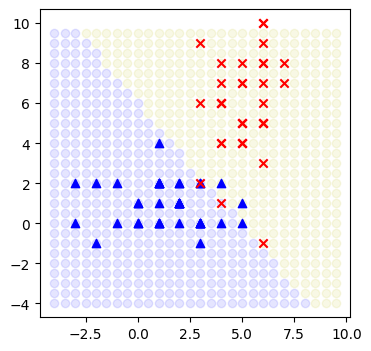

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.079112 

Epoch 176
-------------------------------
loss: 0.069216  [    1/   72]


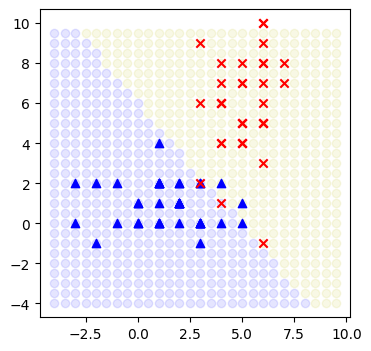

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.078652 

Epoch 177
-------------------------------
loss: 0.068683  [    1/   72]


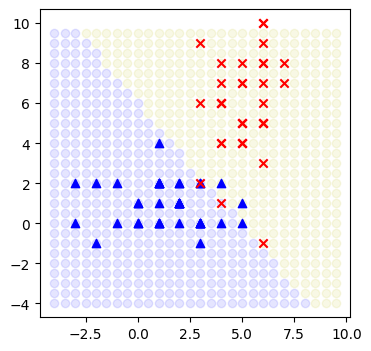

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.078199 

Epoch 178
-------------------------------
loss: 0.068158  [    1/   72]


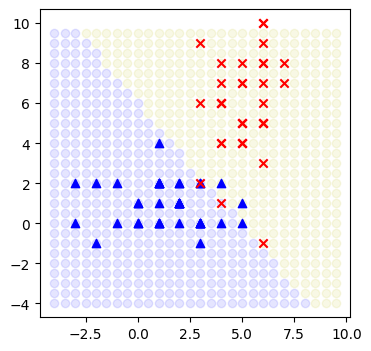

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.077754 

Epoch 179
-------------------------------
loss: 0.067641  [    1/   72]


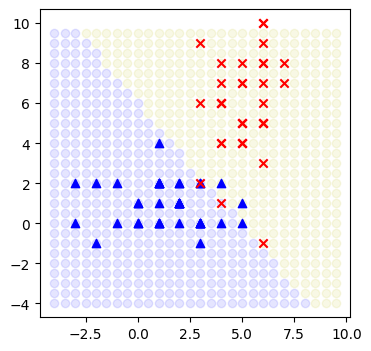

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.077315 

Epoch 180
-------------------------------
loss: 0.067133  [    1/   72]


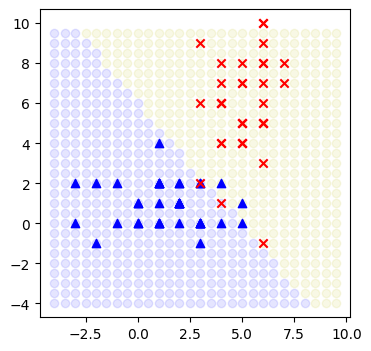

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.076884 

Epoch 181
-------------------------------
loss: 0.066632  [    1/   72]


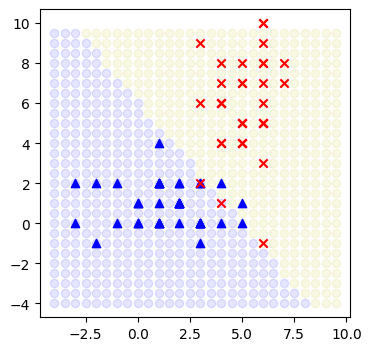

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.076459 

Epoch 182
-------------------------------
loss: 0.066139  [    1/   72]


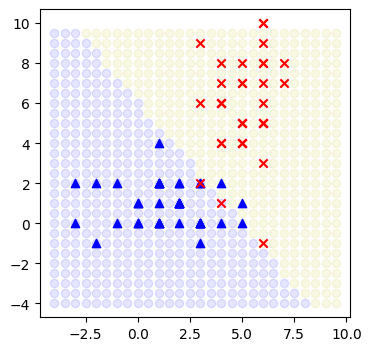

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.076041 

Epoch 183
-------------------------------
loss: 0.065654  [    1/   72]


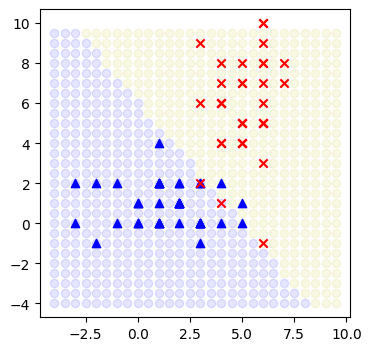

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.075630 

Epoch 184
-------------------------------
loss: 0.065176  [    1/   72]


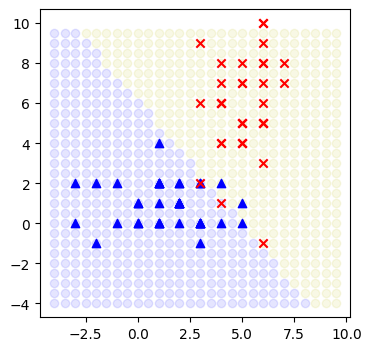

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.075225 

Epoch 185
-------------------------------
loss: 0.064706  [    1/   72]


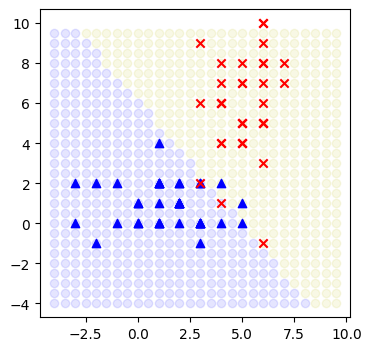

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.074826 

Epoch 186
-------------------------------
loss: 0.064242  [    1/   72]


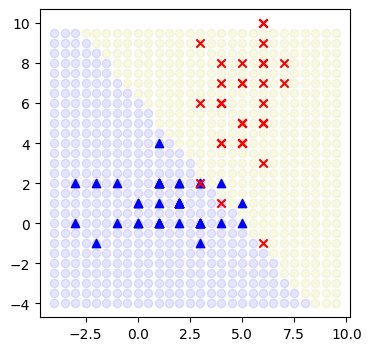

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.074433 

Epoch 187
-------------------------------
loss: 0.063785  [    1/   72]


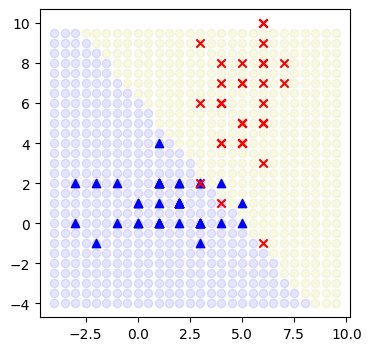

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.074046 

Epoch 188
-------------------------------
loss: 0.063336  [    1/   72]


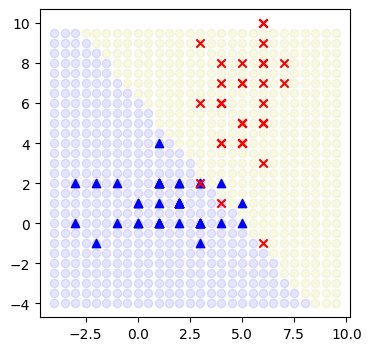

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.073665 

Epoch 189
-------------------------------
loss: 0.062893  [    1/   72]


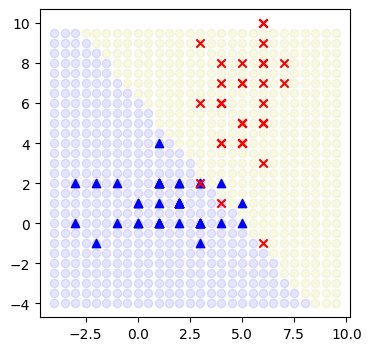

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.073290 

Epoch 190
-------------------------------
loss: 0.062456  [    1/   72]


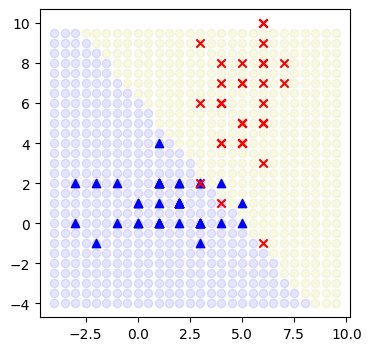

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.072920 

Epoch 191
-------------------------------
loss: 0.062026  [    1/   72]


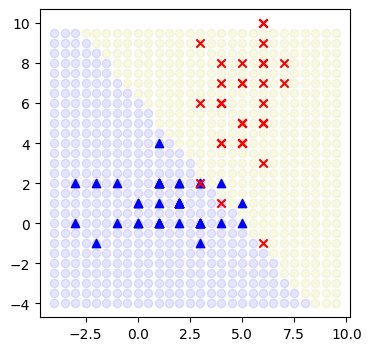

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.072556 

Epoch 192
-------------------------------
loss: 0.061602  [    1/   72]


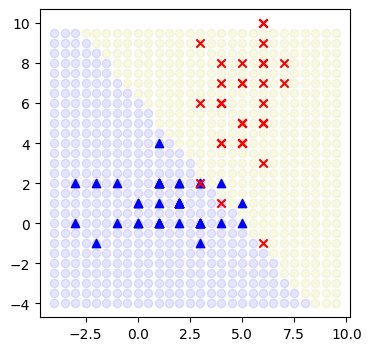

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.072198 

Epoch 193
-------------------------------
loss: 0.061184  [    1/   72]


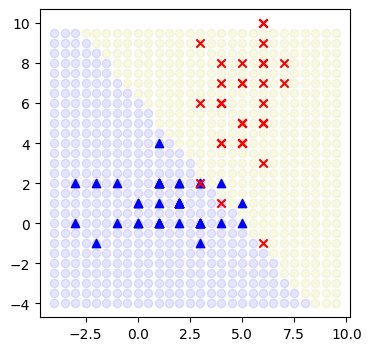

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.071844 

Epoch 194
-------------------------------
loss: 0.060772  [    1/   72]


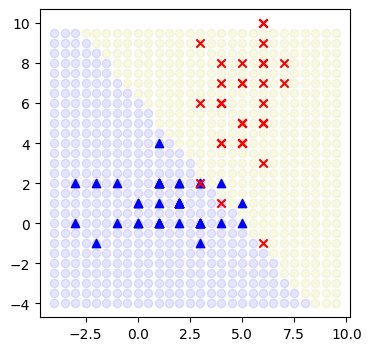

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.071496 

Epoch 195
-------------------------------
loss: 0.060366  [    1/   72]


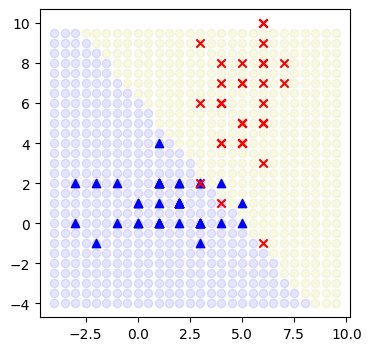

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.071153 

Epoch 196
-------------------------------
loss: 0.059966  [    1/   72]


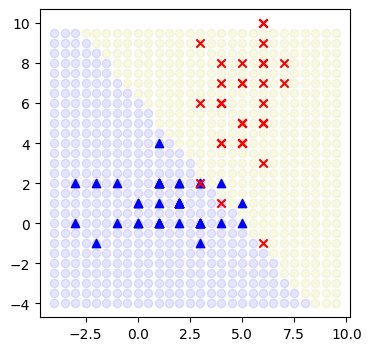

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.070815 

Epoch 197
-------------------------------
loss: 0.059572  [    1/   72]


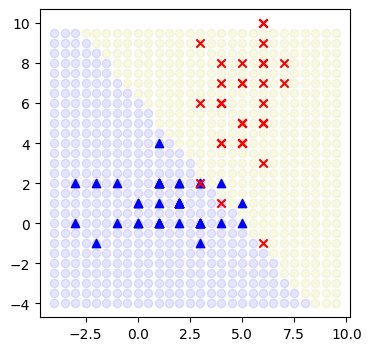

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.070481 

Epoch 198
-------------------------------
loss: 0.059183  [    1/   72]


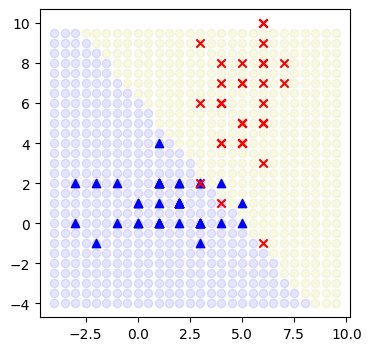

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.070153 

Epoch 199
-------------------------------
loss: 0.058799  [    1/   72]


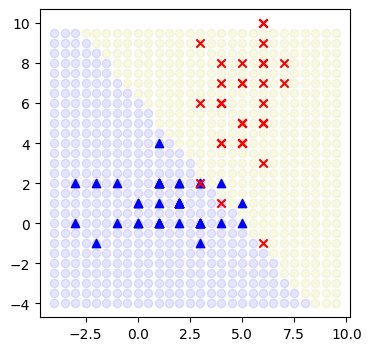

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.069829 

Epoch 200
-------------------------------
loss: 0.058421  [    1/   72]


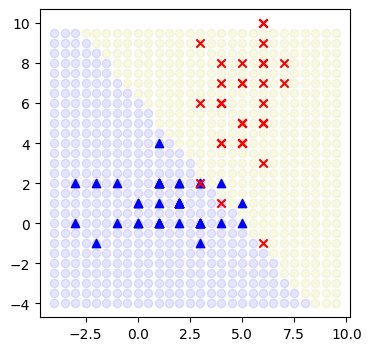

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.069510 

Done!


In [50]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

train_X = torch.Tensor(train_features.T) # transform to torch tensor
train_y = torch.Tensor(train_labels.T)
#print('train_X ', train_X.shape)
#print('train_y ', train_y.shape)
train_dataset = TensorDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset)
#print('train_dl ', type(train_dataloader.dataset))
#print('train_dl ', len(train_dataloader.dataset))

test_X = torch.Tensor(test_features.T) # transform to torch tensor
test_y = torch.Tensor(test_labels.T)
test_dataset = TensorDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset)

# Learn to use pytorch to build the same nn to compare with the self-implement NN

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 2, out_features = 1, bias = True)
        self.A = nn.Sigmoid()
        self.output = nn.Linear(in_features = 1, out_features = 2, bias = True)
    
    def forward(self, x):
        #print('nn forward, x shape:', x.shape)
        x = self.flatten(x)
        logits = self.output(self.A(self.fc1(x)))

        #print('nn forward, after flatten x shape:', x.shape)
        return logits
    
    def show_weights(self):
        #print(self.fc1.weight.data, self.fc1.bias.data,  self.output.weight.data, self.output.bias.data)
        return

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            draw_neuron_boundary_2(model.fc1.weight.data, model.fc1.bias.data, train_features, train_labels, markers, colors)
            #model.show_weights()

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


tNN = TorchNN()
print(tNN)

#loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(tNN.parameters(), lr=learning_rate)

epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, tNN, loss_function, optimizer)
    #tNN.show_weights()
    test_loop(test_dataloader, tNN, loss_function)
print("Done!")


